# Effetto della Legalizzazione della Marijuana sui Tassi di Overdose: un Approccio Difference-in-Differences 

Negli Stati Uniti la crisi degli overdose da droghe (in particolare oppioidi) è un grave problema di sanità pubblica. Contestualmente, sempre più stati hanno adottato leggi di legalizzazione della marijuana, sia per uso medicinale sia per uso ricreativo, soprattutto nel decennio scorso. Questo studio intende valutare in modo rigoroso e causale se e come la legalizzazione della marijuana abbia influenzato i tassi di decessi per overdose. In particolare, si propone un disegno di Difference-in-Differences (DiD) sfruttando dati panel mensili per ciascuno stato USA dal 2015 al 2024 

L’obiettivo è stimare l’effetto medio della legalizzazione sulla variazione dei tassi di overdose, isolando il contributo causale della policy rispetto ad altri trend temporali o differenze strutturali tra stati. 

### Motivazione:
La letteratura esistente offre evidenze miste. Alcuni studi iniziali avevano suggerito che gli stati con leggi sulla marijuana medica registrassero tassi di mortalità per oppiacei più bassi (ad es. circa il 25% in meno rispetto agli stati senza marijuana), ipotizzando che la cannabis potesse sostituire gli oppioidi nella gestione del dolore. Studi più recenti, però, mettono in dubbio questo effetto protettivo, non riscontrando differenze significative nei trend di overdose dopo la legalizzazione sia medica sia ricreative. Ciò rende ancora più importante un’analisi rigorosa: utilizzando il metodo DiD con dati dettagliati, potremo controllare per differenze preesistenti tra stati e fattori temporali comuni, avvicinandoci a un’interpretazione causale dell’effetto della legalizzazione sui tassi di overdose. 

In [684]:
# df
import pandas as pd
import numpy as np
df = pd.read_csv('VSRR_Provisional_Drug_Overdose_Death_Counts.csv')    

(fonte: CDC, dataset mensile per stato sui decessi per overdose)
https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm#:~:text=Provisional%20Drug%20Overdose%20Death%20Counts  

In [685]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + ' ' + df['Month'], format='%Y %B')
df.drop(columns=['Year', 'Month','Period','Footnote','Footnote Symbol'], inplace=True)

In [686]:
# Pivot the data to group by 'State' and 'Date', with 'Indicator' as columns and 'Data Value' as values
pivoted_df = df.pivot_table(index=['State', 'Date'], columns='Indicator', values='Data Value', aggfunc='first').reset_index()
#pivoted_df

In [687]:
pivoted_df

Indicator,State,Date,Cocaine (T40.5),Heroin (T40.1),Methadone (T40.3),Natural & semi-synthetic opioids (T40.2),"Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)","Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)",Number of Deaths,Number of Drug Overdose Deaths,"Opioids (T40.0-T40.4,T40.6)",Percent with drugs specified,Psychostimulants with abuse potential (T43.6),"Synthetic opioids, excl. methadone (T40.4)"
0,AK,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,"4,034",126,NaN,89.68253968,NaN,NaN
1,AK,2015-02-01,NaN,NaN,NaN,NaN,NaN,NaN,"4,084",127,NaN,88.97637795,NaN,NaN
2,AK,2015-03-01,NaN,NaN,NaN,NaN,NaN,NaN,"4,101",125,NaN,88.8,NaN,NaN
3,AK,2015-04-01,NaN,NaN,NaN,NaN,NaN,NaN,"4,133",126,NaN,88.0952381,NaN,NaN
4,AK,2015-05-01,NaN,NaN,NaN,NaN,NaN,NaN,"4,196",125,NaN,86.4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,YC,2024-08-01,"1,377",487,277,263,488,"2,070","55,993","2,598","2,113",99.80754426,239,"1,956"
6476,YC,2024-09-01,"1,352",454,268,249,471,"1,998","55,870","2,523","2,038",99.80182323,237,"1,876"
6477,YC,2024-10-01,"1,285",414,253,226,438,"1,876","55,694","2,385","1,915",99.79035639,227,"1,755"
6478,YC,2024-11-01,"1,238",405,251,211,424,"1,807","55,439","2,309","1,847",99.78345604,226,"1,685"


In [688]:
state_groups = {state: data for state, data in pivoted_df.groupby('State')}
# This allows us to easily select the states we are interested in

### Selezione di uno Stato di Trattamento e di Controllo 

Stato di trattamento (esempio): Massachusetts – ha approvato la legalizzazione ricreativa della marijuana tramite referendum nel novembre 2016ncsl.org, con implementazione effettiva (apertura dei primi negozi) verso la fine del 2018. Massachusetts aveva già legalizzato la marijuana medica qualche anno prima, come molti stati, ma durante il 2015-2016 non consentiva ancora l’uso ricreativo. 

Stato di controllo (esempio): New Hampshire – stato confinante geograficamente e culturalmente simile al Massachusetts, non ha legalizzato l’uso ricreativo durante l’orizzonte 2015-2024 (solo uso medico limitato) e può fungere da gruppo di confronto. Presumibilmente, New Hampshire mostrava un andamento degli overdose simile a quello del Massachusetts nel periodo pre-2018 (entrambi stati del New England colpiti dall’epidemia di oppioidi), condizione che andrà verificata con i dati. 

 Giustificazione della comparabilità: Massachusetts e New Hampshire sono nella stessa area geografica e condividono fattori socio-economici relativamente comparabili. Entrambi hanno affrontato l’epidemia di oppioidi con tendenze crescenti nelle overdose a metà anni 2010. Prima del 2018, nessuno dei due permetteva la marijuana ricreativa, ed entrambi avevano leggi sulla marijuana medica in vigore. 

Caratteristiche socio-demografiche analoghe: ad esempio popolazione, reddito medio, sistema sanitario e presenza di altri interventi (come programmi di accesso a naloxone o regolamentazioni sugli oppioidi) confrontabili, per ridurre bias dovuti a fattori confondenti. 

### Periodo Pre-Trattamento e Post-Trattamento 

Nel caso di Massachusetts (ricreativo), considereremmo il periodo pre-trattamento dall’inizio del dataset (gennaio 2015) fino al momento immediatamente precedente l’entrata in vigore della legalizzazione ricreativa. Poiché il referendum è passato a fine 2016 ma i dispensari ricreativi hanno aperto solo a fine 2018, possiamo definire come pre-trattamento l’intervallo 2015 – metà 2018. Durante questo periodo, né Massachusetts (prima dell’implementazione) né New Hampshire (che non legalizzerà affatto) consentivano uso ricreativo. 

Il periodo post-trattamento inizierà quando la policy inizia a produrre effetti. Possiamo fissare fine 2018 come inizio del post-trattamento per Massachusetts, dato che da quel momento la marijuana ricreativa è effettivamente disponibile legalmente (il primo negozio aprì nel novembre 2018). Dunque il periodo post coprirà grosso modo fine 2018 – 2024. New Hampshire nel frattempo continua a non permettere l’uso ricreativo, ma per coerenza temporale considereremo anche per NH il “post” dal Q4 2018 in avanti

È importante assicurarsi che nel periodo pre-trattamento ci sia abbastanza finestra temporale per osservare i trend basali. Nel dataset 2015–2024 abbiamo almeno 3 anni pieni pre-legalizzazione ricreativa per Massachusetts (2015-2017), il che consente un confronto robusto dei trend pre (ad esempio, verifica della pendenza delle curve di overdose in MA vs NH prima del 2018). Se uno stato avesse legalizzato troppo a ridosso del 2015 (ad es. Colorado nel 2014, prima dell’inizio dati), sarebbe meno adatto perché mancherebbe un periodo pre sufficiente nei dati – in tali casi conviene escluderlo o iniziare l’analisi più tardi da quando si hanno dati pre. 

### Legalizzazione Medica vs Ricreativa: Scelta del “Trattamento” 

Intensità del trattamento: La legalizzazione ricreativa rappresenta un cambiamento più radicale nella disponibilità di cannabis per la popolazione generale rispetto alla medica, che di norma è limitata a pazienti con determinate patologie e prevede iter prescrittivi. Dal punto di vista dell’effetto sugli overdose, l’uso ricreativo potrebbe influire su un pubblico più ampio e avere un impatto sia positivo (ad es. sostituzione di parte del consumo di oppiacei con cannabis) sia negativo (maggiore accesso a una sostanza psicoattiva da parte di persone vulnerabili). L’effetto netto è quindi empiricamente interessante e potenzialmente più misurabile. Dal punto di vista della Diffusione delle politiche, inoltre, ~39 stati su 50 consentivano l’uso medico della cannabis (spesso già da prima del 2015). Al contrario, le legalizzazioni ricreative sono avvenute più gradualmente: finora ~24 stati hanno introdotto l’uso ricreativo 

In [689]:
ma_df = state_groups['MA']

ma_df.rename(columns={
    "Opioids (T40.0-T40.4,T40.6)": "opioids_all",
    "Synthetic opioids, excl. methadone (T40.4)": "synthetic_opioids",
    "Heroin (T40.1)": "heroin",
    "Methadone (T40.3)": "methadone",
    "Cocaine (T40.5)": "cocaine",
    "Psychostimulants with abuse potential (T43.6)": "psychostimulants",
    "Natural & semi-synthetic opioids (T40.2)": "natural_semi_synthetic",
    "Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)": "natural_incl_methadone",
    "Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)": "natural_synthetic_incl_methadone"
}, inplace=True)


Better looking plot for our PP

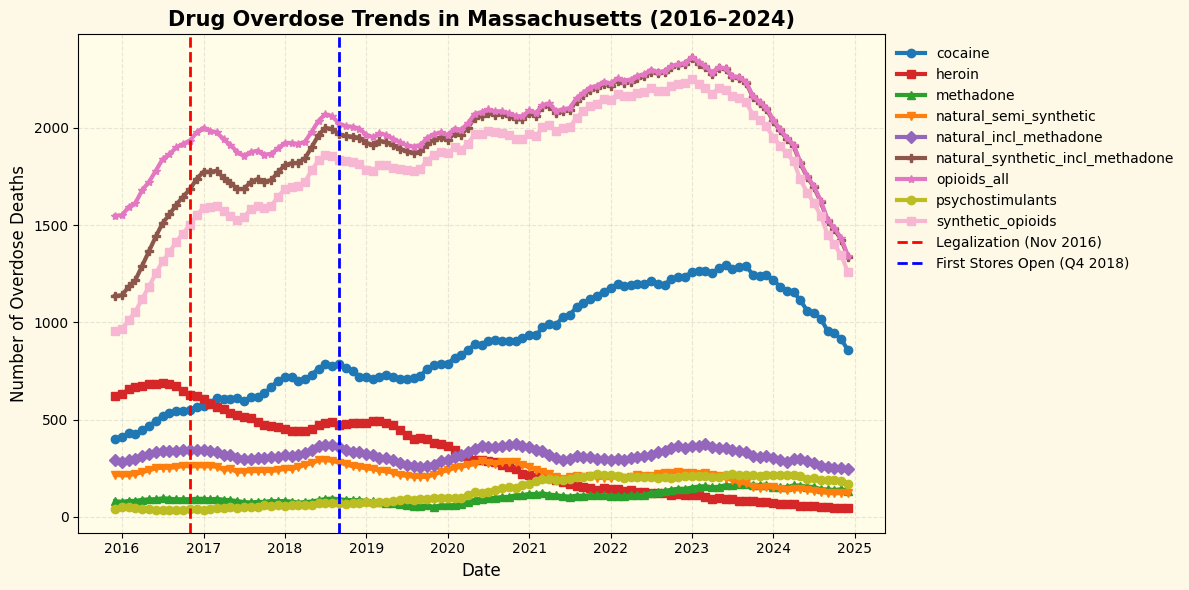

In [690]:

import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
ma_df_cleaned = ma_df.copy()
for col in ma_df.columns[2:]:
    ma_df_cleaned[col] = pd.to_numeric(ma_df[col].str.replace(',', ''), errors='coerce')
ma_df_cleaned = ma_df_cleaned.drop(columns=['Number of Deaths', 'Percent with drugs specified', 'Number of Drug Overdose Deaths'])

# Define a list of distinct, clear colors + marker styles
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#f7b6d2']
markers = ['o', 's', '^', 'v', 'D', 'P', '*']

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#fef9e7')   # light beige
ax.set_facecolor('#fffde7')          # very light yellow/beige

# Plot each drug trend
for i, col in enumerate(ma_df_cleaned.columns[2:]):
    ax.plot(
        ma_df_cleaned['Date'],
        ma_df_cleaned[col],
        label=col,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linewidth=3,
        markersize=6
    )

# Add policy milestone lines
ax.axvline(pd.to_datetime('2016-11-01'), color='red', linestyle='--', linewidth=2, label='Legalization (Nov 2016)')
ax.axvline(pd.to_datetime('2018-09-01'), color='blue', linestyle='--', linewidth=2, label='First Stores Open (Q4 2018)')

# Styling
ax.set_title('Drug Overdose Trends in Massachusetts (2016–2024)', fontsize=15, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Overdose Deaths', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)

# Legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=False)

# Layout fix
plt.tight_layout()
plt.show()

L’impennata di overdose da oppioidi (sintetici e non) è ben visibile prima del 2016, poi la curva inizia ad appiattirsi nel 2017–2018.

Dopo l’apertura dei negozi (settembre 2018, linea blu), alcune categorie di sostanze (come eroina, metadone, e T40.2) continuano a calare, mentre i sintetici (T40.4) e la categoria totale (T40.0–T40.6) mostrano una curva che rallenta la crescita, poi scende leggermente (specie dopo il 2020).

In [691]:
nh_df = state_groups['NH']

nh_df.rename(columns={
    "Opioids (T40.0-T40.4,T40.6)": "opioids_all",
    "Synthetic opioids, excl. methadone (T40.4)": "synthetic_opioids",
    "Heroin (T40.1)": "heroin",
    "Methadone (T40.3)": "methadone",
    "Cocaine (T40.5)": "cocaine",
    "Psychostimulants with abuse potential (T43.6)": "psychostimulants",
    "Natural & semi-synthetic opioids (T40.2)": "natural_semi_synthetic",
    "Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)": "natural_incl_methadone",
    "Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)": "natural_synthetic_incl_methadone"
}, inplace=True)

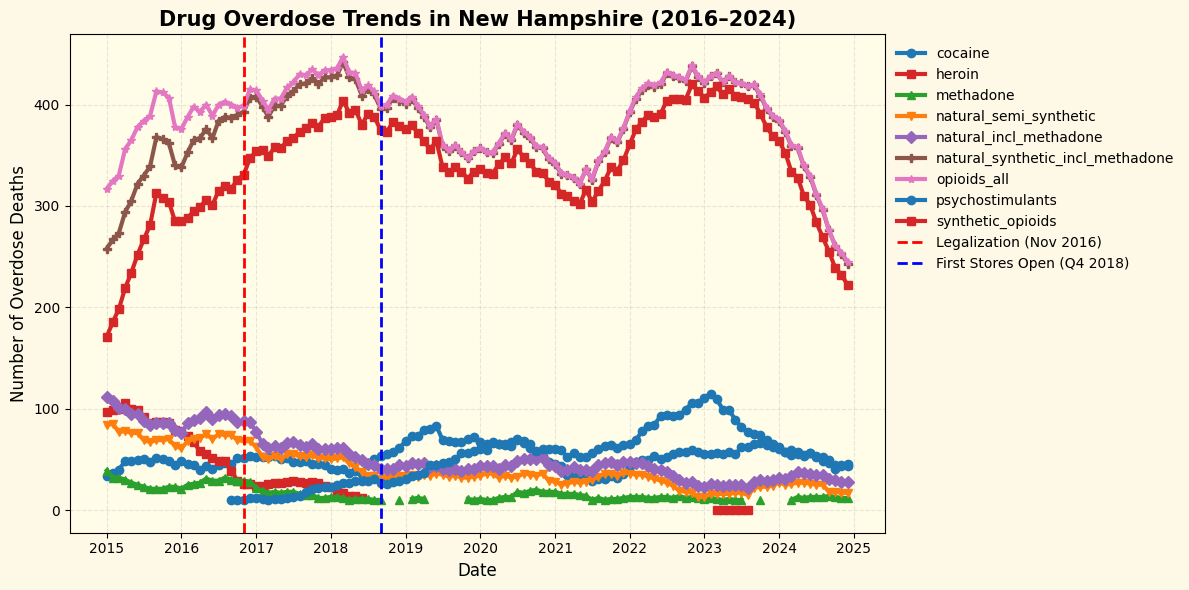

In [692]:

# Prepare data
nh_df = state_groups['NH']
nh_df_cleaned = nh_df.copy()
for col in nh_df_cleaned.columns[2:]:
    nh_df_cleaned[col] = pd.to_numeric(nh_df[col].str.replace(',', ''), errors='coerce')
nh_df_cleaned = nh_df_cleaned.drop(columns=['Number of Deaths', 'Percent with drugs specified', 'Number of Drug Overdose Deaths'])

# Define a list of distinct, clear colors + marker styles
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
markers = ['o', 's', '^', 'v', 'D', 'P', '*']

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#fef9e7')   # light beige
ax.set_facecolor('#fffde7')          # very light yellow/beige

# Plot each drug trend
for i, col in enumerate(nh_df_cleaned.columns[2:]):
    ax.plot(
        nh_df_cleaned['Date'],
        nh_df_cleaned[col],
        label=col,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linewidth=3,
        markersize=6
    )

# Add policy milestone lines
ax.axvline(pd.to_datetime('2016-11-01'), color='red', linestyle='--', linewidth=2, label='Legalization (Nov 2016)')
ax.axvline(pd.to_datetime('2018-09-01'), color='blue', linestyle='--', linewidth=2, label='First Stores Open (Q4 2018)')

# Styling
ax.set_title('Drug Overdose Trends in New Hampshire (2016–2024)', fontsize=15, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Overdose Deaths', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)

# Legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=False)

# Layout fix
plt.tight_layout()
plt.show()


La struttura è simile, ma le curve sono più piatte.

I valori assoluti sono più bassi (in linea con quanto previsto dai tassi di popolazione).

L’effetto del tempo post-settembre 2018 non mostra rotture evidenti nei trend

Le forme delle curve sono simili tra i due stati, anche se i livelli sono diversi.
Questo rafforza la validità dell’assunzione di trend paralleli.

Il trattamento effettivo parte da settembre 2018.


I dati mostrano che il declino inizia dal 2021, suggerendo che potremmo osservare effetti ritardati (→ motivazione per usare anche un event study dinamico con lag post-trattamento).

### 👥 `Population`
- **Significato**: misura la popolazione totale dello stato nel mese considerato.
- **Motivo dell’inclusione**: Stati con più abitanti hanno naturalmente più decessi in valore assoluto. Se non normalizzassimo, potremmo attribuire erroneamente l’effetto alla policy.

---

### 💵 `Minimum_Wage`
- **Significato**: salario minimo orario stabilito per legge.
- **Effetto atteso**: un aumento del salario minimo potrebbe ridurre la vulnerabilità economica, limitando comportamenti di rischio legati alla droga.

---

### 📉 `Unemployment_Rate`
- **Significato**: percentuale della popolazione attiva disoccupata.
- **Effetto atteso**: maggiore disoccupazione può aumentare il disagio sociale, associandosi a maggior rischio di dipendenze e overdose.

---

### 📊 `GDP_per_capita`
- **Significato**: misura del reddito medio pro capite dello stato.
- **Effetto atteso**: un reddito medio più alto potrebbe ridurre la probabilità di comportamenti a rischio, ma potrebbe anche correlarsi con maggiore disponibilità di sostanze.


In [693]:
# nh_df_cleaned
nh_pop = pd.read_csv('NH/NHPOP.csv') # Annual
nh_domestic_product = pd.read_csv('NH/NHNQGSP.csv') # Quarterly
nh_unemployment = pd.read_csv('NH/NHUR.csv') # Monthly
nh_min_wage = pd.read_csv('NH/STTMINWGNH.csv') # Annual

In [694]:
def merge_macro_data_to_monthly(nh_df_cleaned, macro_df, new_column_name, freq):
    """
    Merges macroeconomic data (monthly, quarterly, or annual) into nh_df_cleaned (monthly).
    
    Parameters:
    - nh_df_cleaned: DataFrame with a 'Date' column in monthly frequency
    - macro_df: DataFrame with 2 columns — first: date, second: value
    - new_column_name: Desired name for the merged value column
    - freq: Frequency of macro_df: 'M' (monthly), 'Q' (quarterly), or 'A' (annual)

    Returns:
    - Merged DataFrame with new column
    """
    import pandas as pd

    # Extract date and value
    macro_df = macro_df.iloc[:, :2].copy()
    macro_df.columns = ['Date', new_column_name]
    macro_df['Date'] = pd.to_datetime(macro_df['Date'])

    expanded_rows = []

    for _, row in macro_df.iterrows():
        date = row['Date']
        value = row[new_column_name]

        if freq == 'A':
            # Fill all 12 months of the year
            months = pd.date_range(start=date.replace(month=1), end=date.replace(month=12), freq='MS')
        elif freq == 'Q':
            # Fill 3 months in the quarter
            quarter = (date.month - 1) // 3 + 1
            start_month = (quarter - 1) * 3 + 1
            months = pd.date_range(start=date.replace(month=start_month), periods=3, freq='MS')
        elif freq == 'M':
            # Just keep the month itself
            months = [pd.Timestamp(date.replace(day=1))]
        else:
            raise ValueError("Frequency must be one of: 'A' (annual), 'Q' (quarterly), 'M' (monthly)")

        for m in months:
            expanded_rows.append({'Date': m, new_column_name: value})

    # Build expanded macro DataFrame
    expanded_df = pd.DataFrame(expanded_rows)

    # Normalize nh_df_cleaned dates to first of the month
    nh_df_cleaned['Date'] = pd.to_datetime(nh_df_cleaned['Date']).dt.to_period('M').dt.to_timestamp()

    # Merge
    merged_df = nh_df_cleaned.merge(expanded_df, on='Date', how='left')

    return merged_df


In [695]:
nh_df_cleaned['Date'] = pd.to_datetime(nh_df_cleaned['Date'])  # ensure datetime
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_pop, new_column_name='Population', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_min_wage, new_column_name='Minimum Wage', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_domestic_product, new_column_name='GDP', freq='Q')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_unemployment, new_column_name='Unemployment Rate', freq='M')


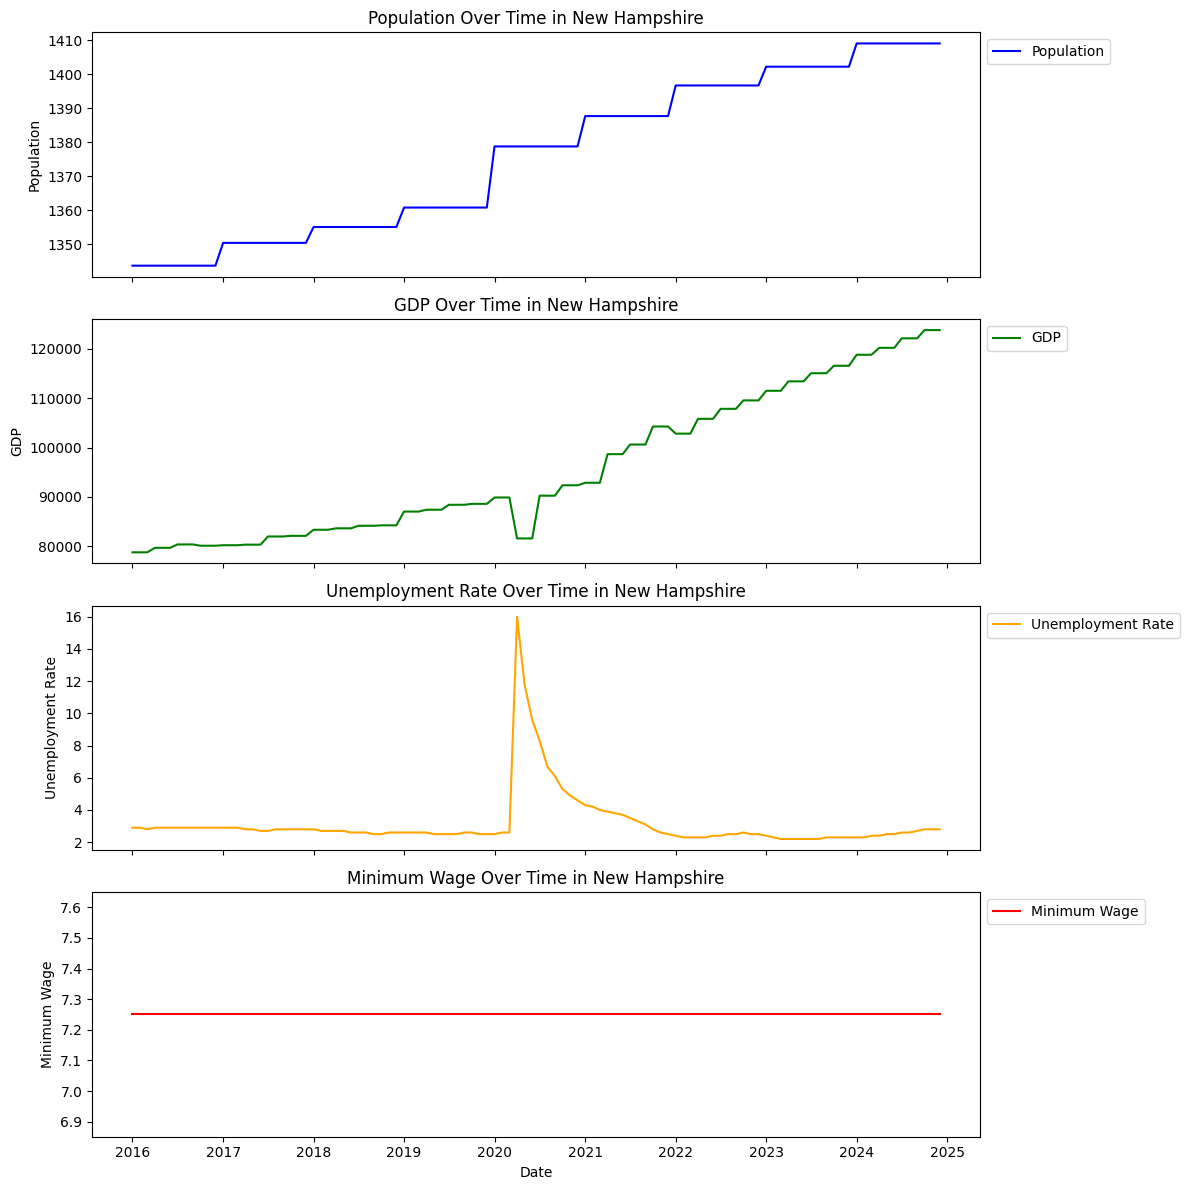

In [696]:
# 4 subplots
# plot population, gdp, unemployment rate, minimum wage
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
# Plot Population
axs[0].plot(nh_df_cleaned['Date'], nh_df_cleaned['Population'], label='Population', color='blue')
axs[0].set_ylabel('Population')
axs[0].set_title('Population Over Time in New Hampshire')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot GDP
axs[1].plot(nh_df_cleaned['Date'], nh_df_cleaned['GDP'], label='GDP', color='green')
axs[1].set_ylabel('GDP')
axs[1].set_title('GDP Over Time in New Hampshire')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot Unemployment Rate
axs[2].plot(nh_df_cleaned['Date'], nh_df_cleaned['Unemployment Rate'], label='Unemployment Rate', color='orange')
axs[2].set_ylabel('Unemployment Rate')
axs[2].set_title('Unemployment Rate Over Time in New Hampshire')
axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot Minimum Wage
axs[3].plot(nh_df_cleaned['Date'], nh_df_cleaned['Minimum Wage'], label='Minimum Wage', color='red')
axs[3].set_ylabel('Minimum Wage')
axs[3].set_title('Minimum Wage Over Time in New Hampshire')
axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add x-axis label
axs[3].set_xlabel('Date')
plt.tight_layout()
plt.show()
        

https://norml.org/marijuana/library/state-marijuana-arrests/new-hampshire-marijuana-arrests/

In [697]:
import pandas as pd

# Step 1: Manually create the DataFrame from the extracted data
nh_arrest_data = pd.DataFrame({
    'Date': pd.date_range(start='2018-01-01', periods=6, freq='YS'),  # One date per year
    'Possession': [2639, 2333, 1494, 1120, 913, 694],
    'Sales': [212, 233, 160, 123, 82, 97],
    'Total Arrests': [2851, 2566, 1654, 1243, 995, 791],
    'MJ Arrests (%)': [43.0, 21.0, 38.0, 35.0, 30.0, 30.05],
    'Agencies (%)': [91, 91, 86, 82, 88, 83]
})


### 👮‍♂️ `MJ_Arrests (%)` e `Agencies (%)`
- **MJ_Arrests (%)**: percentuale di arresti legati alla marijuana sul totale.
- **Agencies (%)**: copertura percentuale delle forze dell’ordine che segnalano i dati.
- **Interpretazione**: alta presenza di arresti legati alla marijuana potrebbe indicare un sistema repressivo, che si riflette anche nella gestione delle droghe pesanti. Una copertura maggiore (`Agencies (%)`) implica dati più affidabili.

---

### 👮‍♀️ `Arrests_per_100k`, `Possession_per_100k`, `Sales_per_100k`
- **Significato**: tassi di arresti per droghe totali, per possesso, e per vendita.
- **Effetto atteso**: controllano per la severità dell’enforcement; più arresti → più controlli, ma anche più uso diffuso → endogeneità potenziale.


In [698]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def impute_missing_years(df, value_col):
    """
    Imputes missing years: interpolates 2017 from 2018–2019,
    extrapolates 2016 from 2018+, and 2024 from full range.

    Parameters:
    - df: DataFrame with 'Date' and a value column
    - value_col: Name of the value column to impute

    Returns:
    - DataFrame with Date and value_col, including 2016, 2017, 2024
    """
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df = df.sort_values('Year')

    ### STEP 1: Interpolate 2017 from 2018–2019
    if 2018 in df['Year'].values and 2019 in df['Year'].values:
        y_2018 = df[df['Year'] == 2018][value_col].values[0]
        y_2019 = df[df['Year'] == 2019][value_col].values[0]
        value_2017 = y_2018 - (y_2019 - y_2018)  # simple linear trend backward
        row_2017 = {'Date': pd.Timestamp('2017-01-01'), value_col: value_2017}
    else:
        raise ValueError("Need 2018 and 2019 to interpolate 2017")

    ### STEP 2: Extrapolate 2016 from 2018+
    df_post2018 = df[df['Year'] >= 2018]
    model_back = LinearRegression()
    model_back.fit(df_post2018[['Year']], df_post2018[value_col])
    value_2016 = model_back.predict([[2016]])[0]
    row_2016 = {'Date': pd.Timestamp('2016-01-01'), value_col: value_2016}

    ### STEP 3: Extrapolate 2024 from full data
    df_all = pd.concat([df, pd.DataFrame([row_2017])], ignore_index=True)
    df_all['Year'] = df_all['Date'].dt.year
    model_forward = LinearRegression()
    model_forward.fit(df_all[['Year']], df_all[value_col])
    value_2024 = model_forward.predict([[2024]])[0]
    row_2024 = {'Date': pd.Timestamp('2024-01-01'), value_col: value_2024}

    ### STEP 4: Combine and return
    filled_df = pd.concat([df, pd.DataFrame([row_2016, row_2017, row_2024])], ignore_index=True)
    filled_df = filled_df.sort_values('Date')[['Date', value_col]]

    return filled_df

In [699]:
from functools import reduce

filled_nh_possession = impute_missing_years(nh_arrest_data[['Date', 'Possession']], 'Possession')
filled_nh_sales = impute_missing_years(nh_arrest_data[['Date', 'Sales']], 'Sales')
filled_nh_total = impute_missing_years(nh_arrest_data[['Date', 'Total Arrests']], 'Total Arrests')
filled_nh_mj = impute_missing_years(nh_arrest_data[['Date', 'MJ Arrests (%)']], 'MJ Arrests (%)')
filled_nh_agencies = impute_missing_years(nh_arrest_data[['Date', 'Agencies (%)']], 'Agencies (%)')

# Merge them all
nh_filled = reduce(lambda left, right: pd.merge(left, right, on='Date'), [
    filled_nh_possession, filled_nh_sales, filled_nh_total, filled_nh_mj, filled_nh_agencies
])

c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\minic

In [700]:
# Merge the imputed NH data into nh_df_cleaned
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_filled[['Date', 'Possession']], 'Possession', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_filled[['Date', 'Sales']], 'Sales', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_filled[['Date', 'Total Arrests']], 'Total Arrests', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_filled[['Date', 'MJ Arrests (%)']], 'MJ Arrests (%)', freq='A')
nh_df_cleaned = merge_macro_data_to_monthly(nh_df_cleaned, nh_filled[['Date', 'Agencies (%)']], 'Agencies (%)', freq='A')

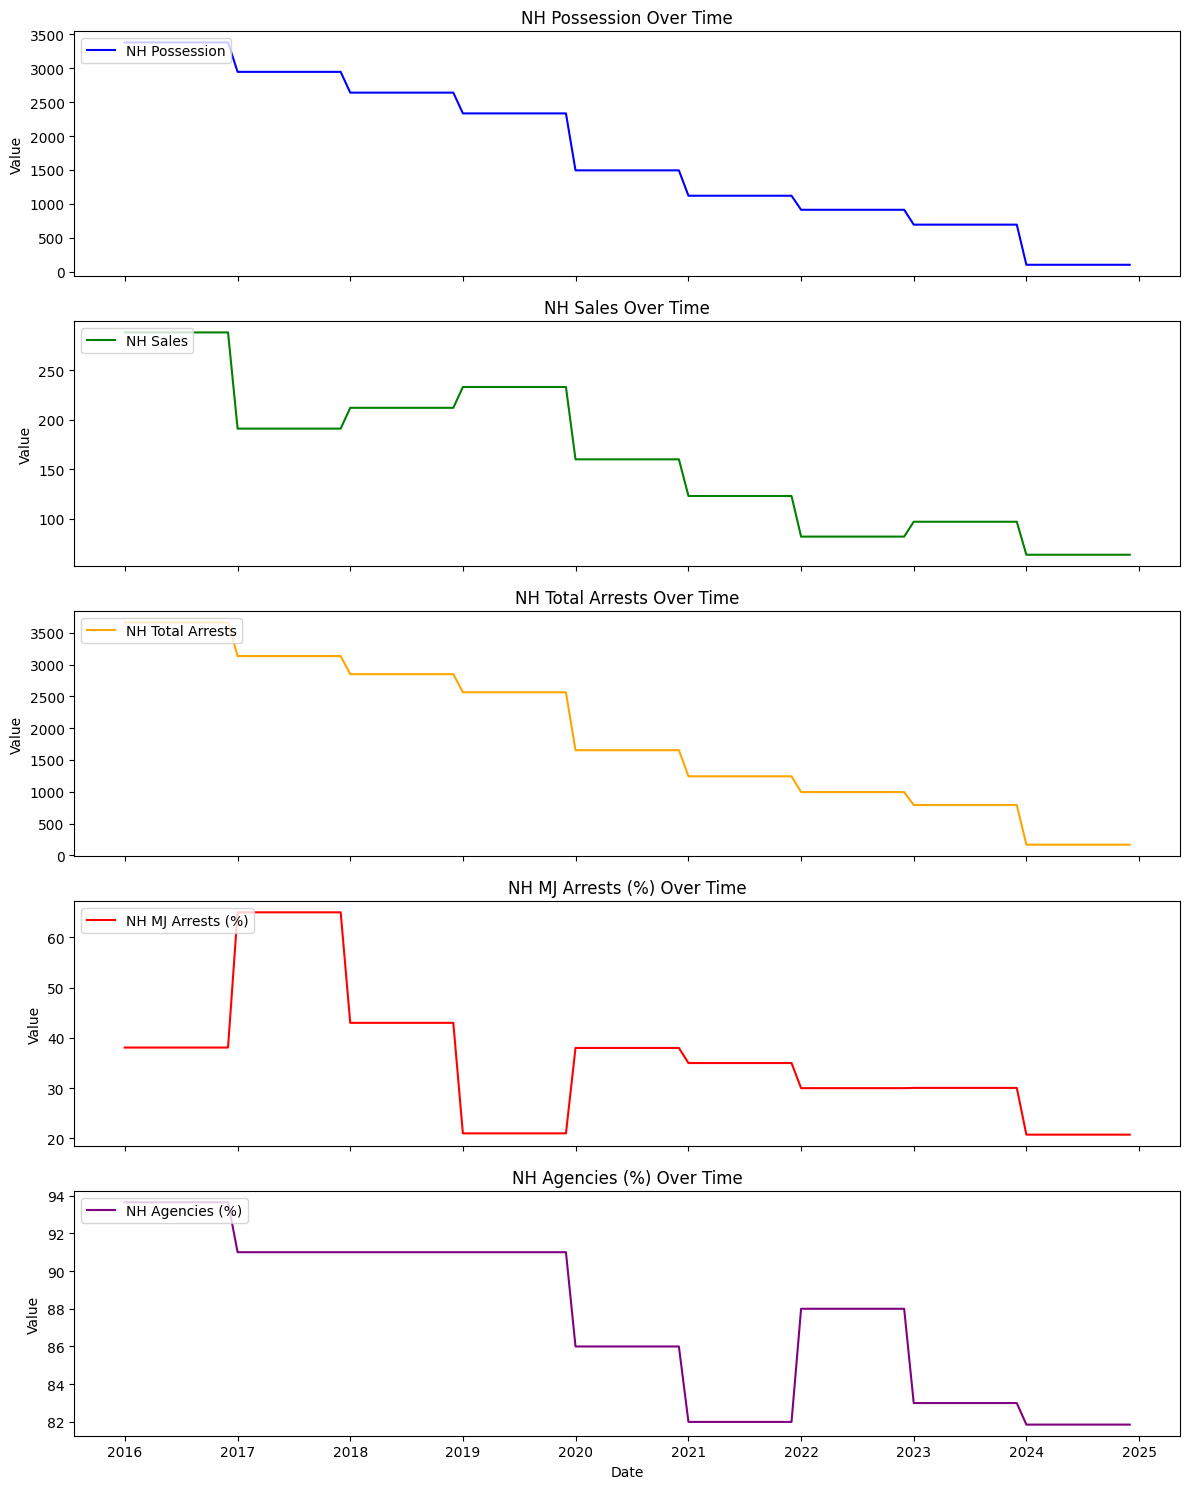

In [701]:
# Filter data for the desired time range
filtered_nh_df = nh_df_cleaned[(nh_df_cleaned['Date'] >= '2016-01-01') & (nh_df_cleaned['Date'] <= '2024-12-31')]

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# Plot NH Possession
axs[0].plot(filtered_nh_df['Date'], filtered_nh_df['Possession'], label='NH Possession', color='blue')
axs[0].set_ylabel('Value')
axs[0].set_title('NH Possession Over Time')
axs[0].legend(loc='upper left')

# Plot NH Sales
axs[1].plot(filtered_nh_df['Date'], filtered_nh_df['Sales'], label='NH Sales', color='green')
axs[1].set_ylabel('Value')
axs[1].set_title('NH Sales Over Time')
axs[1].legend(loc='upper left')

# Plot NH Total Arrests
axs[2].plot(filtered_nh_df['Date'], filtered_nh_df['Total Arrests'], label='NH Total Arrests', color='orange')
axs[2].set_ylabel('Value')
axs[2].set_title('NH Total Arrests Over Time')
axs[2].legend(loc='upper left')

# Plot NH MJ Arrests (%)
axs[3].plot(filtered_nh_df['Date'], filtered_nh_df['MJ Arrests (%)'], label='NH MJ Arrests (%)', color='red')
axs[3].set_ylabel('Value')
axs[3].set_title('NH MJ Arrests (%) Over Time')
axs[3].legend(loc='upper left')

# Plot NH Agencies (%)
axs[4].plot(filtered_nh_df['Date'], filtered_nh_df['Agencies (%)'], label='NH Agencies (%)', color='purple')
axs[4].set_ylabel('Value')
axs[4].set_title('NH Agencies (%) Over Time')
axs[4].legend(loc='upper left')

# Add x-axis label
axs[4].set_xlabel('Date')

# Adjust layout
plt.tight_layout()
plt.show()

https://www.sos.nh.gov/party-registration-history-1970-2025

In [702]:
import pandas as pd

# Parsed voter registration snapshots
voter_data = [
    ("January 1, 2016", 229202, 260896, 383834, None, 873932),
    ("April 1, 2016", 272480, 297074, 347254, None, 916808),
    ("August 1, 2016", 269263, 293307, 354082, None, 916652),
    ("October 1, 2016", 271455, 295687, 351984, None, 919126),
    ("November 1, 2016", 288808, 308808, 409786, None, 1007402),
    ("January 1, 2017", 279044, 305368, 403816, None, 988228),
    ("April 1, 2017", 276817, 303328, 404717, 58, 984920),
    ("November 1, 2017", 272111, 294273, 394033, 120, 960537),
    ("February 1, 2018", 268343, 295615, 397699, 162, 961819),
    ("April 1, 2018", 267241, 294240, 399245, 209, 960935),
    ("September 1, 2018", 278764, 296553, 386390, 689, 962396),
    ("December 1, 2018", 284174, 307360, 415316, 1154, 1008004),
    ("May 1, 2019", 278134, 294512, 410389, None, 983035),
    ("November 1, 2019", 275973, 289814, 413345, None, 979132),
    ("January 1, 2020", 275252, 288524, 413593, None, 977369),
    ("April 1, 2020", 323430, 301720, 377754, None, 1002904),
    ("August 1, 2020", 316926, 297972, 386548, None, 1001446),
    ("September 1, 2020", 328488, 306954, 375100, None, 1010542),
    ("November 1, 2020", 347828, 333165, 438239, None, 1119232),
    ("January 1, 2021", 339269, 323090, 424879, None, 1087238),
    ("April 1, 2021", 337937, 321051, 425655, None, 1084643),
    ("June 1, 2021", 326735, 309281, 408092, None, 1044108),
    ("September 1, 2021", 277720, 267526, 324802, None, 870048),
    ("February 1, 2022", 276206, 265768, 327365, None, 869339),
    ("May 1, 2022", 275220, 265116, 330466, None, 870802),
    ("September 1, 2022", 273921, 263934, 332008, None, 869863),
    ("June 1, 2023", 280170, 278463, 348163, None, 906796),
    ("August 1, 2023", 276332, 275514, 344817, None, 896663),
    ("November 1, 2023", 264356, 269153, 344242, None, 877751),
    ("January 1, 2024", 262262, 267905, 343192, None, 873359),
    ("April 1, 2024", 260281, 304375, 325920, None, 890576),
    ("July 1, 2024", 257983, 300949, 331586, None, 890518),
    ("October 1, 2024", 268943, 308223, 318221, None, 895387),
    ("February 1, 2025", 277076, 325221, 379789, None, 982086),
    ("May 1, 2025", 275280, 324101, 380695, None, 980076),
]

# Create DataFrame
voter_df = pd.DataFrame(voter_data, columns=[
    'Date', 'Democratic', 'Republican', 'Undeclared', 'Libertarian', 'Total'
])
voter_df['Date'] = pd.to_datetime(voter_df['Date'])


### 🗳️ `Voters_percentage`
- **Significato**: percentuale della popolazione registrata al voto.
- **Interpretazione**: può essere proxy per l’engagement civico, che può riflettere governance, fiducia istituzionale e sensibilità alle politiche pubbliche.

---

### 🟦🔴 `Democratic_percentage`, `Republican_percentage`, `Undeclared_percentage`
- **Significato**: distribuzione politica degli elettori registrati.
- **Effetto atteso**:
  - Stati a maggioranza **democratica** tendono ad approvare più facilmente riforme come la legalizzazione.
  - Stati a maggioranza **repubblicana** potrebbero avere enforcement più severo.
  - **Indipendenti** possono catturare dinamiche politiche locali o indecisione dell’elettorato.


In [703]:
def expand_voter_data_monthly(voter_df, start='2016-01-01', end='2026-04-01'):
    """
    Expands snapshot-based voter data into a full monthly time series by forward-filling.
    Each row of voter_df is assumed to represent a change that takes effect the *same month*.

    Returns:
    - A monthly DataFrame with 'Date' as the first of the month and voter data forward-filled.
    """
    # Generate a monthly date range
    monthly_index = pd.date_range(start=start, end=end, freq='MS')  # 'MS' ensures start of the month
    monthly_df = pd.DataFrame({'Date': monthly_index})

    # Sort snapshots and ensure dates are at the start of the month
    voter_df_sorted = voter_df.sort_values('Date').copy()
    voter_df_sorted['Date'] = voter_df_sorted['Date'].dt.to_period('M').dt.to_timestamp('M')
    # Merge and forward-fill
    filled_df = pd.merge_asof(monthly_df, voter_df_sorted, on='Date')
    return filled_df

In [704]:
nh_voter_df = expand_voter_data_monthly(voter_df)
# Refill the first row of voter_monthly_df using the first row of voter_df
nh_voter_df.loc[0] = voter_df.iloc[0]
nh_voter_df.sort_values('Date', inplace=True)  # Ensure the DataFrame remains sorted by Date
nh_voter_df.reset_index(drop=True, inplace=True)

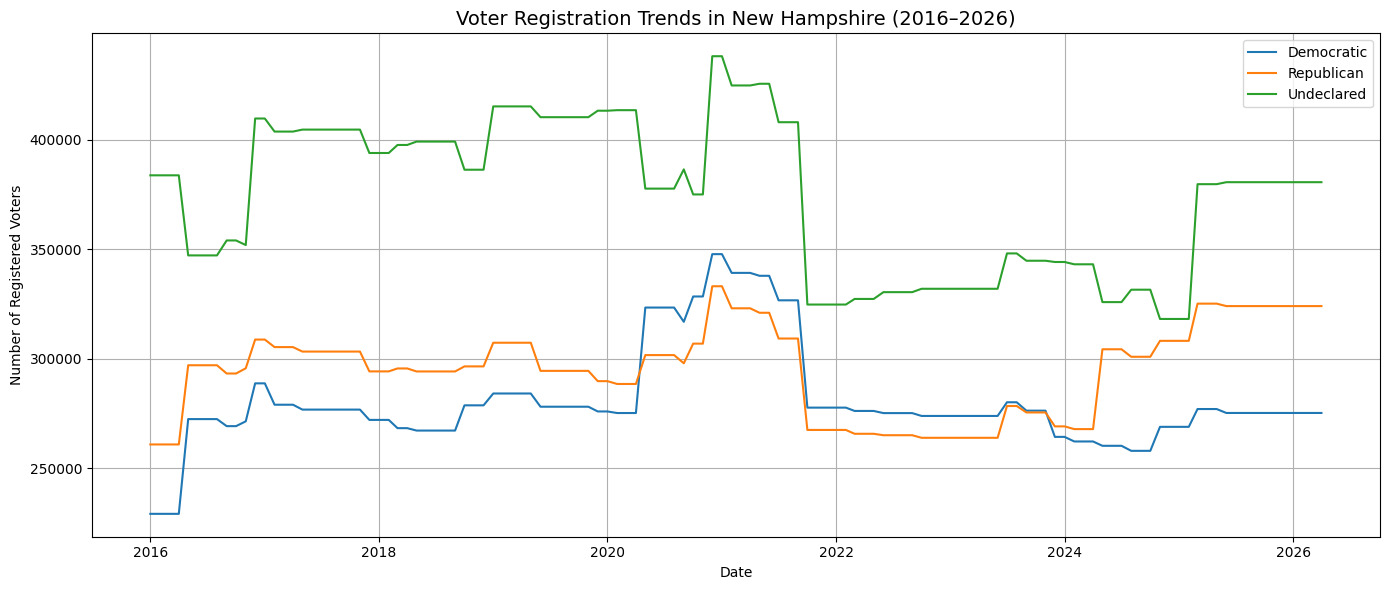

In [705]:
nh_voter_df.drop(columns=['Libertarian'], inplace=True)

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 6))

# Plot each party
plt.plot(nh_voter_df['Date'], nh_voter_df['Democratic'], label='Democratic')
plt.plot(nh_voter_df['Date'], nh_voter_df['Republican'], label='Republican')
plt.plot(nh_voter_df['Date'], nh_voter_df['Undeclared'], label='Undeclared')

# Style
plt.title("Voter Registration Trends in New Hampshire (2016–2026)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Registered Voters")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [706]:
# Ensure both DataFrames have the same date format
nh_voter_df['Date'] = pd.to_datetime(nh_voter_df['Date'])
filtered_nh_df['Date'] = pd.to_datetime(filtered_nh_df['Date'])

# Merge the voter data into the original nh_df
nh_df_merged = filtered_nh_df.merge(nh_voter_df, on='Date', how='left')

# Display the merged DataFrame
#nh_df_merged

C:\Users\emanu\AppData\Local\Temp\ipykernel_13280\15383300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nh_df['Date'] = pd.to_datetime(filtered_nh_df['Date'])


In [707]:
# ma_df_cleaned
ma_pop = pd.read_csv('MA/MAPOP.csv')
ma_domestic_product = pd.read_csv('MA/MANQGSP.csv')
ma_unemployment = pd.read_csv('MA/MAUR.csv')
ma_min_wage = pd.read_csv('MA/STTMINWGMA.csv')

In [708]:
ma_df_cleaned['Date'] = pd.to_datetime(ma_df_cleaned['Date'])  # ensure datetime
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_pop, new_column_name='Population', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_min_wage, new_column_name='Minimum Wage', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_domestic_product, new_column_name='GDP', freq='Q')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_unemployment, new_column_name='Unemployment Rate', freq='M')

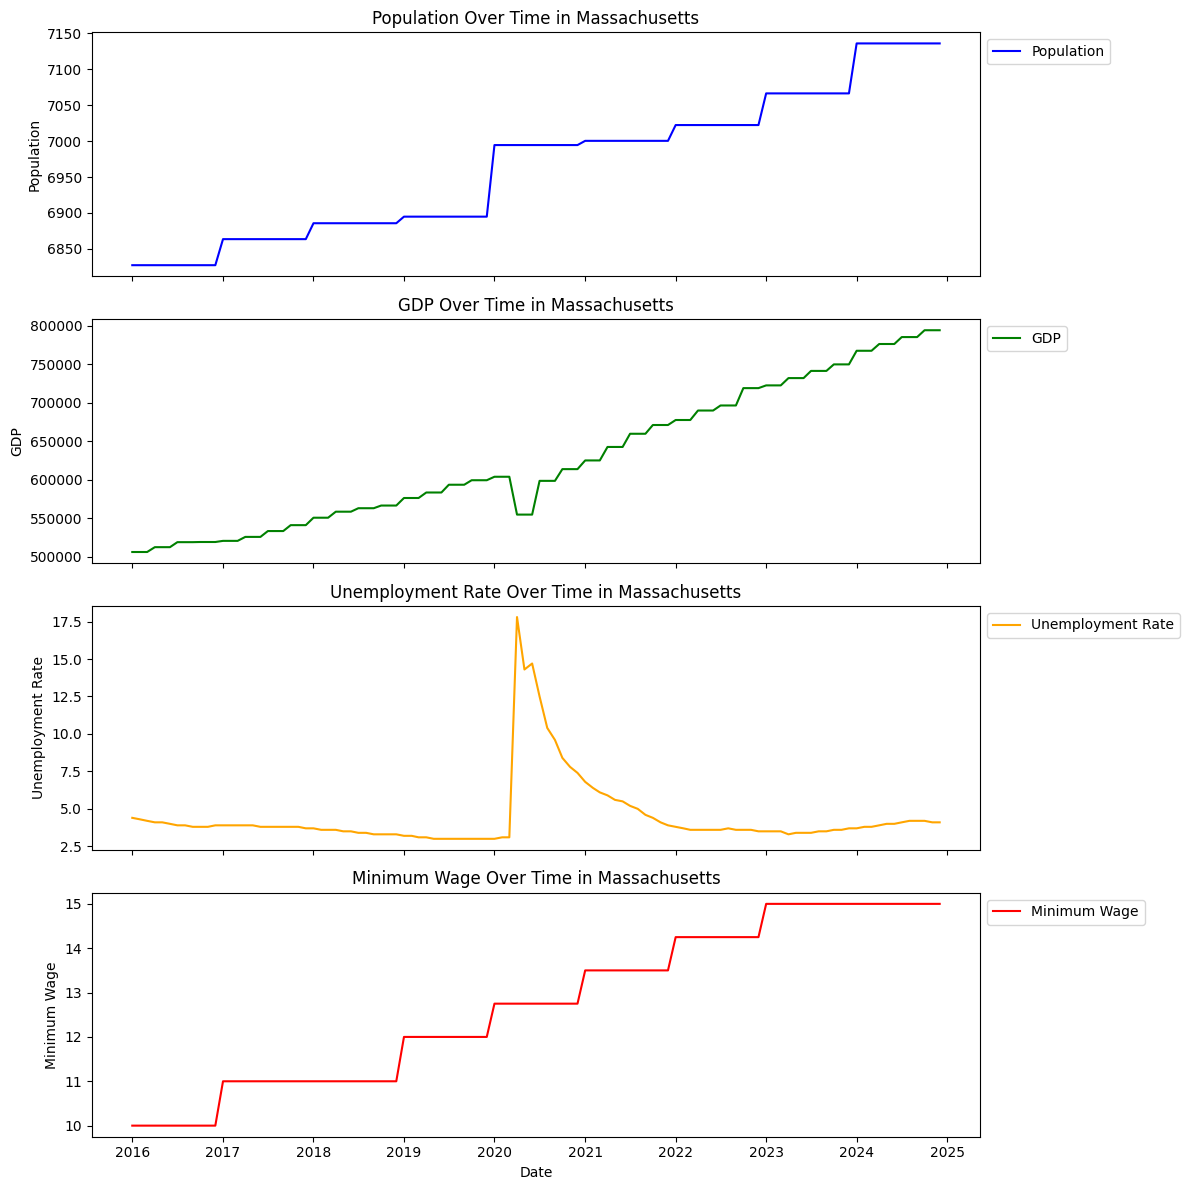

In [709]:
# 4 subplots
# plot population, gdp, unemployment rate, minimum wage
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
# Plot Population
axs[0].plot(ma_df_cleaned['Date'], ma_df_cleaned['Population'], label='Population', color='blue')
axs[0].set_ylabel('Population')
axs[0].set_title('Population Over Time in Massachusetts')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot GDP
axs[1].plot(ma_df_cleaned['Date'], ma_df_cleaned['GDP'], label='GDP', color='green')
axs[1].set_ylabel('GDP')
axs[1].set_title('GDP Over Time in Massachusetts')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot Unemployment Rate
axs[2].plot(ma_df_cleaned['Date'], ma_df_cleaned['Unemployment Rate'], label='Unemployment Rate', color='orange')
axs[2].set_ylabel('Unemployment Rate')
axs[2].set_title('Unemployment Rate Over Time in Massachusetts')
axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Plot Minimum Wage
axs[3].plot(ma_df_cleaned['Date'], ma_df_cleaned['Minimum Wage'], label='Minimum Wage', color='red')
axs[3].set_ylabel('Minimum Wage')
axs[3].set_title('Minimum Wage Over Time in Massachusetts')
axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add x-axis label
axs[3].set_xlabel('Date')
plt.tight_layout()
plt.show()
        

https://norml.org/marijuana/library/state-marijuana-arrests/massachusetts-marijuana-arrests/

In [710]:
import pandas as pd

ma_arrest_data = pd.DataFrame({
    'Date': pd.date_range(start='2018-01-01', periods=6, freq='YS'),
    'Possession': [185, 213, 132, 71, 92, 114],
    'Sales': [450, 456, 234, 148, 169, 180],
    'Total Arrests': [635, 669, 366, 219, 261, 294],
    'MJ Arrests (%)': [7.0, 21.0, 6.0, 4.0, 5.9, 5.73],
    'Agencies (%)': [82, 85, 84, 89, 86, 85]
})


In [711]:
filled_ma_possession = impute_missing_years(ma_arrest_data[['Date', 'Possession']], 'Possession')
filled_ma_sales = impute_missing_years(ma_arrest_data[['Date', 'Sales']], 'Sales')
filled_ma_total = impute_missing_years(ma_arrest_data[['Date', 'Total Arrests']], 'Total Arrests')
filled_ma_mj = impute_missing_years(ma_arrest_data[['Date', 'MJ Arrests (%)']], 'MJ Arrests (%)')
filled_ma_agencies = impute_missing_years(ma_arrest_data[['Date', 'Agencies (%)']], 'Agencies (%)')

# Merge them all
from functools import reduce
ma_filled = reduce(lambda left, right: pd.merge(left, right, on='Date'), [
    filled_ma_possession, filled_ma_sales, filled_ma_total, filled_ma_mj, filled_ma_agencies
])

c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\emanu\minic

In [712]:
# Merge the imputed MA data into ma_df_cleaned
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_filled[['Date', 'Possession']], 'Possession', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_filled[['Date', 'Sales']], 'Sales', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_filled[['Date', 'Total Arrests']], 'Total Arrests', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_filled[['Date', 'MJ Arrests (%)']], 'MJ Arrests (%)', freq='A')
ma_df_cleaned = merge_macro_data_to_monthly(ma_df_cleaned, ma_filled[['Date', 'Agencies (%)']], 'Agencies (%)', freq='A')

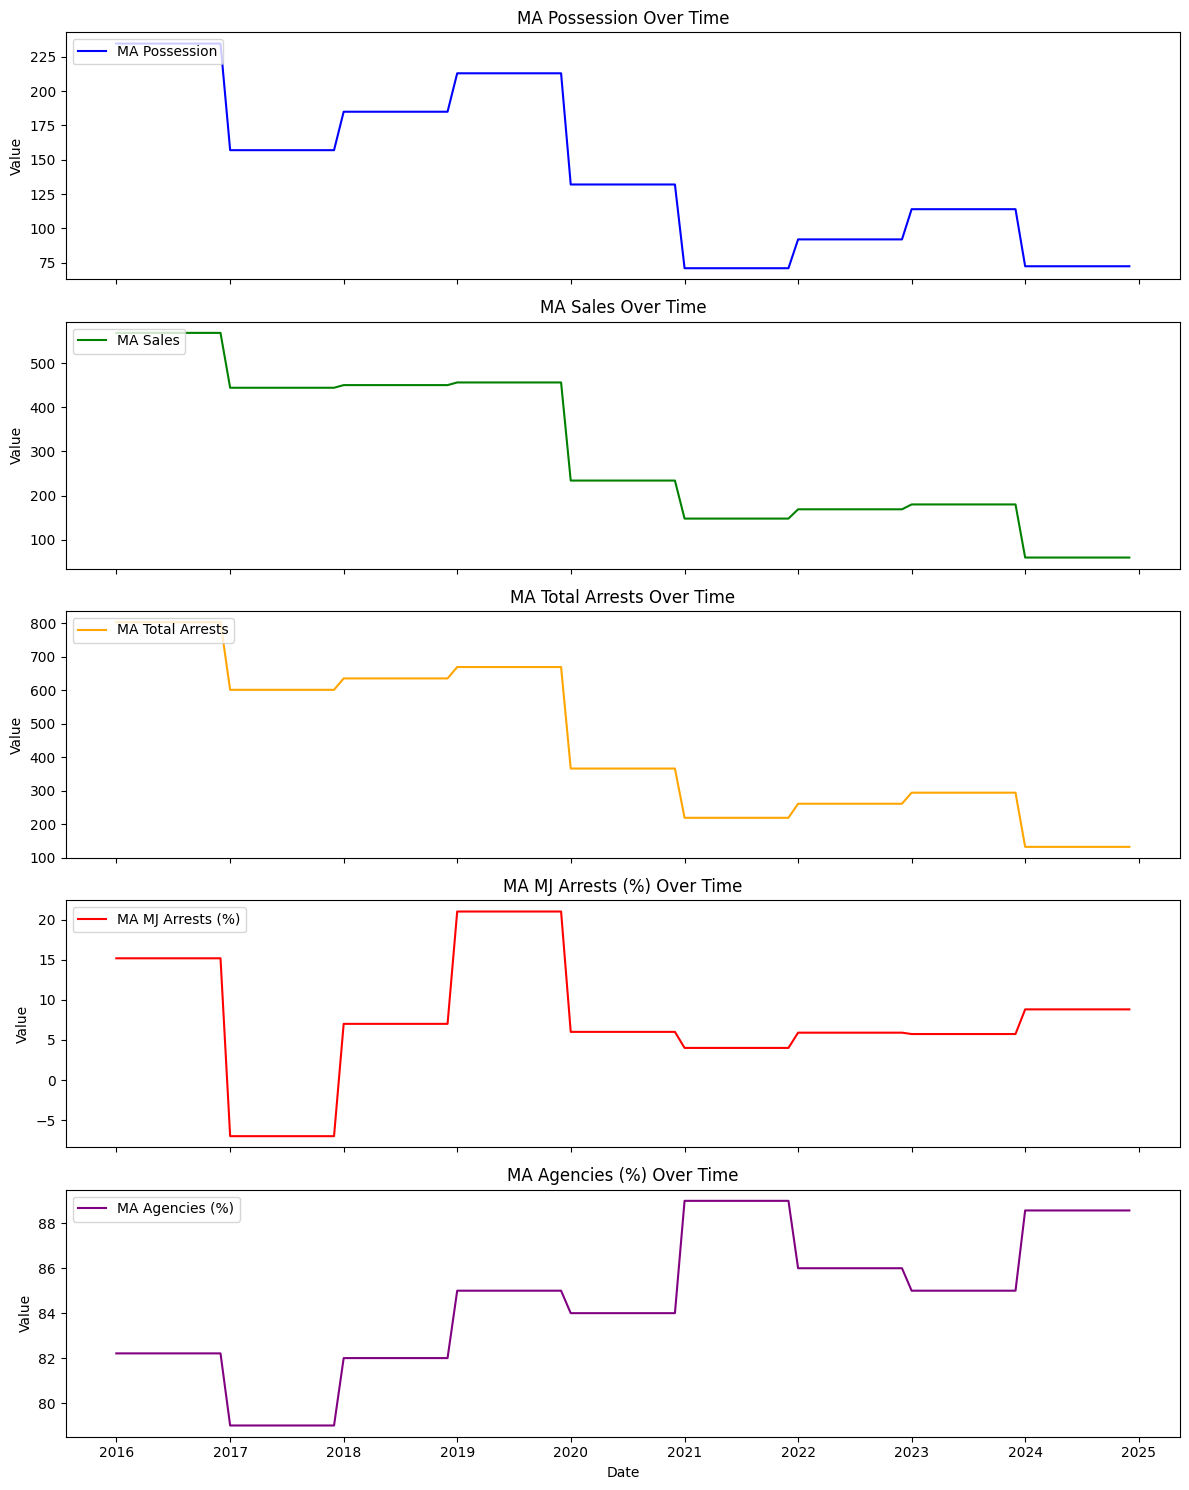

In [713]:
# Filter data for the desired time range
filtered_ma_df = ma_df_cleaned[(ma_df_cleaned['Date'] >= '2016-01-01') & (ma_df_cleaned['Date'] <= '2024-12-31')]

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# Plot MA Possession
axs[0].plot(filtered_ma_df['Date'], filtered_ma_df['Possession'], label='MA Possession', color='blue')
axs[0].set_ylabel('Value')
axs[0].set_title('MA Possession Over Time')
axs[0].legend(loc='upper left')

# Plot MA Sales
axs[1].plot(filtered_ma_df['Date'], filtered_ma_df['Sales'], label='MA Sales', color='green')
axs[1].set_ylabel('Value')
axs[1].set_title('MA Sales Over Time')
axs[1].legend(loc='upper left')

# Plot MA Total Arrests
axs[2].plot(filtered_ma_df['Date'], filtered_ma_df['Total Arrests'], label='MA Total Arrests', color='orange')
axs[2].set_ylabel('Value')
axs[2].set_title('MA Total Arrests Over Time')
axs[2].legend(loc='upper left')

# Plot MA MJ Arrests (%)
axs[3].plot(filtered_ma_df['Date'], filtered_ma_df['MJ Arrests (%)'], label='MA MJ Arrests (%)', color='red')
axs[3].set_ylabel('Value')
axs[3].set_title('MA MJ Arrests (%) Over Time')
axs[3].legend(loc='upper left')

# Plot MA Agencies (%)
axs[4].plot(filtered_ma_df['Date'], filtered_ma_df['Agencies (%)'], label='MA Agencies (%)', color='purple')
axs[4].set_ylabel('Value')
axs[4].set_title('MA Agencies (%) Over Time')
axs[4].legend(loc='upper left')

# Add x-axis label
axs[4].set_xlabel('Date')

# Adjust layout
plt.tight_layout()
plt.show()

https://www.sec.state.ma.us/divisions/elections/research-and-statistics/registered-voter-enrollment.htm

In [714]:
import pandas as pd

# Manually cleaned values from your image (summed other parties where multiple are present)
ma_voter_data_clean = [
    ("2016-01-01", 4271835, 1490335	, 468295, 5413 + 25425, 13684, 2277760),
    ("2016-08-01", 4366712, 1509113, 473220, 5413 + 25425, 13978, 2339565),
    ("2016-10-01", 4534974, 1549828, 484508, 5799 + 30368, 16650, 2447821),
    ("2017-02-01", 4486849, 1526870, 479237, 8587, 47176, 2424979),
    ("2018-08-01", 4493007, 1492399, 465952, 14271, 45850, 2474535),
    ("2018-10-01", 4574967, 1514607, 471383, 15787, 45442, 2527748),
    ("2019-02-01", 4434934, 1458305, 456527, 3744 + 16893, 39637, 2459828),
    ("2020-02-01", 4581319, 1491600, 462586, 3807 + 19851, 39399, 2564076),
    ("2020-09-01", 4666299, 1499898, 459913, 3666 + 18803, 38767, 2645252),
    ("2020-10-01", 4812909, 1534549, 476480, 3793 + 19097, 39564, 2739426),
    ("2021-02-01", 4731940, 1494980, 459663, 60004, None, 2717293),
    ("2022-08-01", 4838359, 1434356, 436379, 56356, None, 2911268),
    ("2022-10-01", 4884076, 1438607, 437211, 56395, None, 2951863),
    ("2023-02-01", 4781556, 1386550, 421333, 16548, 36750, 2920375),
    ("2024-02-01", 4957403, 1336825, 415438, 16307, 35388, 3153445),
    ("2024-08-01", 5054539, 1327704, 418899, 16137, 35045, 3256754),
    ("2024-10-01", 5142343, 1352937, 434887, 16467, 35559, 3302493),
    ("2025-02-01", 5025826, 1298603, 423387, None, 49401, 3254435),
]

# Create DataFrame
voter_df = pd.DataFrame(ma_voter_data_clean, columns=[
    'Date', 'Registered Voters', 'Democratic', 'Republican',
    'Other Parties', 'Political Designations', 'Unenrolled'
])
voter_df['Date'] = pd.to_datetime(voter_df['Date'])


In [715]:
ma_voter_df = expand_voter_data_monthly(voter_df)
# Refill the first row of ma_voter_monthly using the first row of voter_df
ma_voter_df.loc[0] = voter_df.iloc[0]
ma_voter_df.sort_values('Date', inplace=True)  # Ensure the DataFrame remains sorted by Date
ma_voter_df.reset_index(drop=True, inplace=True)
ma_voter_df.rename(columns={'Unenrolled': 'Undeclared'}, inplace=True)

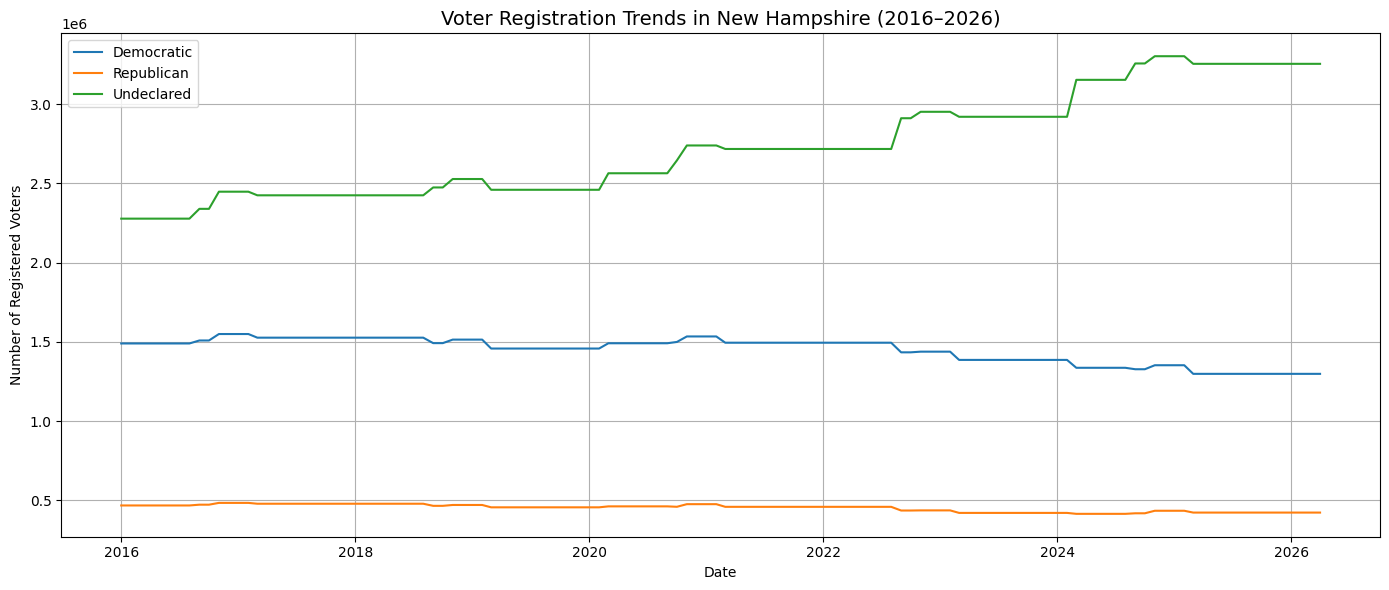

In [716]:
ma_voter_df.drop(columns=['Political Designations','Other Parties'], inplace=True)

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 6))

# Plot each party
plt.plot(ma_voter_df['Date'], ma_voter_df['Democratic'], label='Democratic')
plt.plot(ma_voter_df['Date'], ma_voter_df['Republican'], label='Republican')
plt.plot(ma_voter_df['Date'], ma_voter_df['Undeclared'], label='Undeclared')

# Style
plt.title("Voter Registration Trends in New Hampshire (2016–2026)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Registered Voters")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [717]:
# Ensure both DataFrames have the same date format
ma_voter_df['Date'] = pd.to_datetime(ma_voter_df['Date'])
filtered_ma_df['Date'] = pd.to_datetime(filtered_ma_df['Date'])

# Merge the voter data into the original nh_df
ma_df_merged = filtered_ma_df.merge(ma_voter_df, on='Date', how='left')

# Display the merged DataFrame
#ma_df_merged

C:\Users\emanu\AppData\Local\Temp\ipykernel_13280\447416098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ma_df['Date'] = pd.to_datetime(filtered_ma_df['Date'])


### Data Eng

Population is by thousand so we don't multiply by 100000 but by 100

In [718]:
ma_df_merged["GDP_per_capita"] = ma_df_merged["GDP"] / ma_df_merged["Population"] * 1000
ma_df_merged["Arrests_per_100k"] = (ma_df_merged["Total Arrests"] / ma_df_merged["Population"]) * 100
ma_df_merged["Possession_per_100k"] = (ma_df_merged["Possession"] / ma_df_merged["Population"]) * 100
ma_df_merged["Sales_per_100k"] = (ma_df_merged["Sales"] / ma_df_merged["Population"]) * 100
ma_df_merged["Voters_percentage"] = (ma_df_merged["Registered Voters"] / ma_df_merged["Population"]) * 100
ma_df_merged["Democratic_percentage"] = (ma_df_merged["Democratic"] / ma_df_merged["Registered Voters"]) * 100
ma_df_merged["Republican_percentage"] = (ma_df_merged["Republican"] / ma_df_merged["Registered Voters"]) * 100
ma_df_merged["Undeclared_percentage"] = (ma_df_merged["Undeclared"] / ma_df_merged["Registered Voters"]) * 100
ma_df_merged.drop(columns=['GDP','Total Arrests','Possession','Sales','Registered Voters','Democratic','Republican','Undeclared'], inplace=True)


In [719]:
nh_df_merged["GDP_per_capita"] = nh_df_merged["GDP"] / nh_df_merged["Population"] * 1000
nh_df_merged["Arrests_per_100k"] = (nh_df_merged["Total Arrests"] / nh_df_merged["Population"]) * 100
nh_df_merged["Possession_per_100k"] = (nh_df_merged["Possession"] / nh_df_merged["Population"]) * 100
nh_df_merged["Sales_per_100k"] = (nh_df_merged["Sales"] / nh_df_merged["Population"]) * 100
nh_df_merged["Voters_percentage"] = (nh_df_merged["Total"] / nh_df_merged["Population"]) * 100
nh_df_merged["Democratic_percentage"] = (nh_df_merged["Democratic"] / nh_df_merged["Total"]) * 100
nh_df_merged["Republican_percentage"] = (nh_df_merged["Republican"] / nh_df_merged["Total"]) * 100
nh_df_merged["Undeclared_percentage"] = (nh_df_merged["Undeclared"] / nh_df_merged["Total"]) * 100
nh_df_merged.drop(columns=['GDP', 'Total Arrests', 'Possession', 'Sales', 'Total', 'Democratic', 'Republican', 'Undeclared'], inplace=True)

In [720]:
df = pd.concat([ma_df_merged, nh_df_merged], ignore_index=True)


In [721]:
df['Covid_t'] = ((df['Date'] >= '2020-03-01') & (df['Date'] <= '2021-12-31')).astype(int)
# I was almost forgptting to add the most important dummy...

In [722]:
df["treated"] = (df["State"] == "MA").astype(int)
df["post"] = (df["Date"] >= "2018-10-01").astype(int)
df["treated_post"] = df["treated"] * df["post"]


In [723]:
# cols with Nans
df.columns[df.isna().any()].tolist()
# if needed we gonna impute the values and analyze those also, for now drop

['heroin', 'methadone', 'psychostimulants']

In [724]:
# List of columns to calculate missing percentages
columns = ['heroin', 'methadone', 'psychostimulants']

# Calculate percentage of missing values for each column
missing_percentages = {col: (df[col].isna().sum() / len(df)) * 100 for col in columns}

# Display the results
missing_percentages

{'heroin': 33.33333333333333,
 'methadone': 6.944444444444445,
 'psychostimulants': 3.7037037037037033}

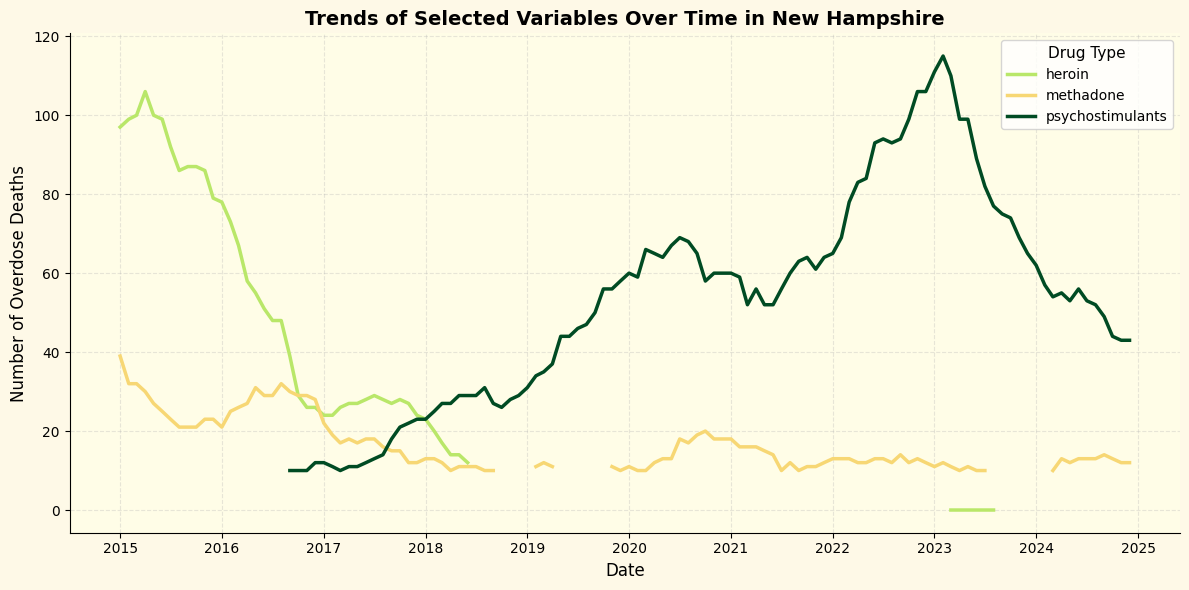

In [725]:
import matplotlib.pyplot as plt

# Define color mapping
color_map = {
    'heroin': '#B9E769',      # light green
    'methadone': '#F7D774',   # yellow
    'psychostimulants': '#004B23'  # dark green
}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#fef9e7')   # overall background
ax.set_facecolor('#fffde7')          # plot area background

# Plot each variable with matching color and style
for column, color in color_map.items():
    ax.plot(nh_df_cleaned['Date'], nh_df_cleaned[column], label=column, color=color, linewidth=2.5)

# Add labels and title
ax.set_title('Trends of Selected Variables Over Time in New Hampshire', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Overdose Deaths', fontsize=12)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title='Drug Type', fontsize=10, title_fontsize=11)

# Clean up spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


C:\Users\emanu\AppData\Local\Temp\ipykernel_13280\3461971843.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_data_percentage.keys(), fontsize=11)


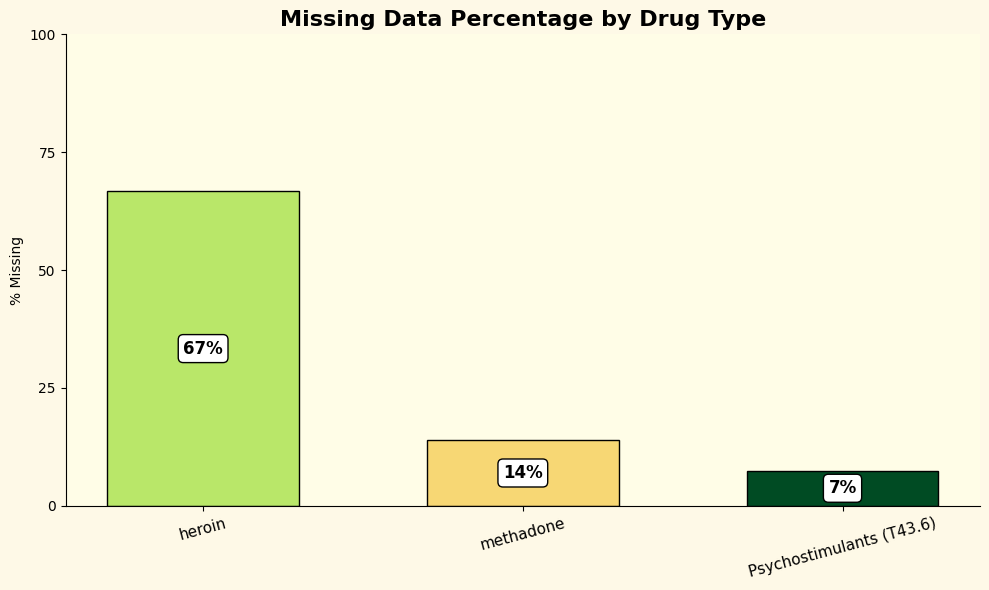

In [726]:
import matplotlib.pyplot as plt

# Sample input (replace with actual calculation if needed)
missing_data_percentage = {
    'heroin': 33.33*2,
    'methadone': 6.94*2,
    'Psychostimulants (T43.6)': 3.70*2
}

# Colors matching the infographic
colors = ['#B9E769', '#F7D774', '#004B23']

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#fef9e7')   # soft beige background
ax.set_facecolor('#fffde7')

# Bar plot
bars = ax.bar(
    list(missing_data_percentage.keys()),
    list(missing_data_percentage.values()),
    color=colors,
    edgecolor='black',
    width=0.6
)

# Add percentage labels inside boxes
for bar, value in zip(bars, missing_data_percentage.values()):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f'{value:.0f}%',
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black')
    )

# Title and axes
ax.set_title('Missing Data Percentage by Drug Type', fontsize=16, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_ylabel('% Missing')
ax.set_xticklabels(missing_data_percentage.keys(), fontsize=11)
ax.tick_params(axis='x', rotation=15)

# Remove top and right border
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()



In [727]:
#!pip install pykalman

The Kalman Filter assumes that each observation depends on a hidden "true" state that evolves over time. It uses a state-space model with:

A transition equation (how the state evolves)

An observation equation (how observed values relate to the hidden state)

Train on observed (non-missing) values
The filter is initialized and trained using only the available data. It estimates parameters like noise variances and initial state using Expectation-Maximization (EM).

Smooth the series to infer missing values
Once trained, the Kalman Filter applies smoothing, which means it estimates each value by combining:

Past information (filtering)

Future information (smoothing)

Fill in the gaps
The smoothed hidden states are used to replace missing entries with the most likely value, based on the full temporal context.



In [728]:
df_imp = df.copy()

In [729]:
# Assicurati che la colonna Date sia di tipo datetime
df_imp["Date"] = pd.to_datetime(df_imp["Date"])
# Imposta la colonna Date come indice e forza la frequenza mensile
df_imp = df_imp.set_index("Date").sort_index()
#df_imp = df_imp.asfreq("M")  # MS = Month Start
# Rimuovi eventuali duplicati nella colonna Date
#df_imp = df_imp.drop_duplicates(subset="Date")

In [730]:
from statsmodels.tsa.seasonal import seasonal_decompose
outcome_columns  = [
    'opioids_all', 'synthetic_opioids', 'cocaine',
    'natural_semi_synthetic', 'natural_incl_methadone',
    'natural_synthetic_incl_methadone'
]

seasonal_data = []

for col in outcome_columns:
    series = df[col]
    if len(series) >= 24:
        try:
            result = seasonal_decompose(series, model="additive", period=12)
            seasonal_data.append({
                "Variable": col,
                "Trend Std": result.trend.std(skipna=True),
                "Seasonal Std": result.seasonal.std(),
                "Resid Std": result.resid.std(skipna=True),
                "Max Seasonal Effect": result.seasonal.max(),
                "Min Seasonal Effect": result.seasonal.min(),
                "Amplitude": result.seasonal.max() - result.seasonal.min()
            })
        except Exception as e:
            print(f"{col}: {e}")


In [731]:
seasonal_df = pd.DataFrame(seasonal_data)
seasonal_df

,Variable,Trend Std,Seasonal Std,Resid Std,Max Seasonal Effect,Min Seasonal Effect,Amplitude
0,opioids_all,821.938763,15.556738,67.392116,23.778799,-25.806985,49.585784
1,synthetic_opioids,765.241031,15.556803,68.428691,24.246732,-25.368464,49.615196
2,cocaine,455.377198,13.516245,56.363321,19.878881,-22.434845,42.313725
3,natural_semi_synthetic,97.131766,0.962618,7.701700,1.391136,-1.795139,3.186275
4,natural_incl_methadone,135.972780,3.075901,13.512603,4.808619,-4.769812,9.578431
5,natural_synthetic_incl_methadone,800.784038,16.109087,69.894521,24.788194,-26.545139,51.333333


In [732]:
df_nh = df[df['State'] == 'NH'].copy()
df_ma = df[df['State'] == 'MA'].copy()

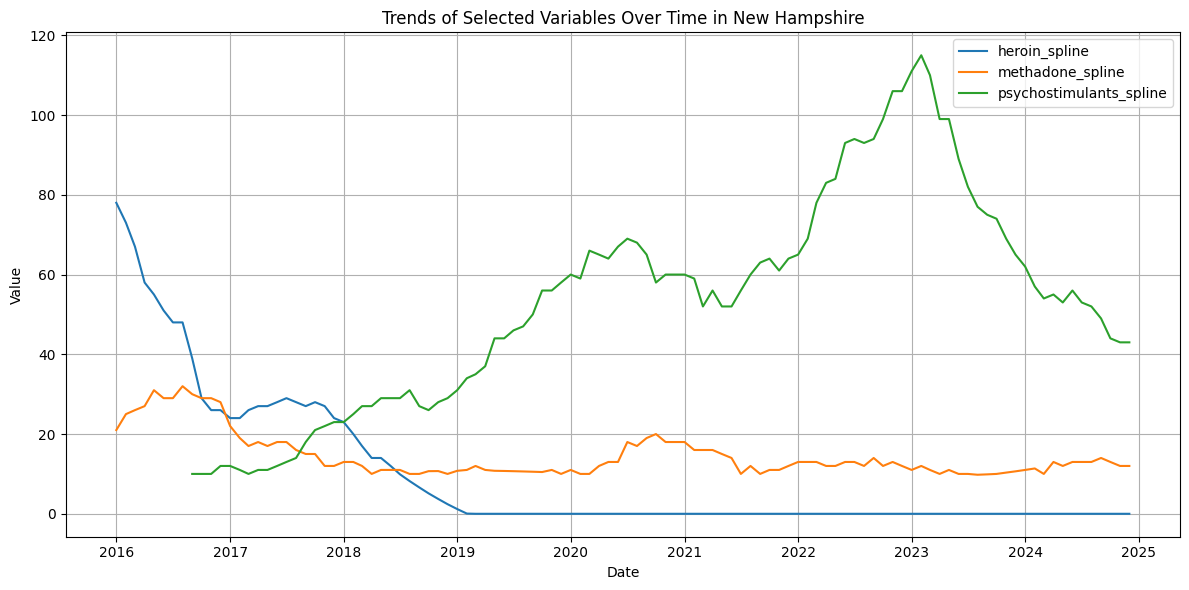

In [733]:
df_nh['heroin_spline'] = df_nh['heroin'].interpolate(method='spline', order=3).clip(lower=0)
df_nh['methadone_spline'] = df_nh['methadone'].interpolate(method='spline', order=3).clip(lower=0)
df_nh['psychostimulants_spline'] = df_nh['psychostimulants'].interpolate(method='spline', order=3).clip(lower=0)

#df_nh['heroin_poly2'] = df_nh['heroin'].interpolate(method='polynomial', order=2)
#df_nh['methadone_poly2'] = df_nh['methadone'].interpolate(method='polynomial', order=2)
#df_nh['psychostimulants_poly2'] = df_nh['psychostimulants'].interpolate(method='polynomial', order=2)

#df_nh['heroin_smooth'] = df_nh['heroin'].rolling(window=5, center=True).mean()
#df_nh['methadone_smooth'] = df_nh['methadone'].rolling(window=5, center=True).mean()
#df_nh['psychostimulants_smooth'] = df_nh['psychostimulants'].rolling(window=5, center=True).mean()

# Plot the selected variables
plt.figure(figsize=(12, 6))
for column in ['heroin_spline', 'methadone_spline', 'psychostimulants_spline']:
#for column in ['heroin_poly2', 'methadone_poly2', 'psychostimulants_poly2']:
#for column in ['heroin_smooth', 'methadone_smooth', 'psychostimulants_smooth']:
    plt.plot(df_nh['Date'], df_nh[column], label=column)

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends of Selected Variables Over Time in New Hampshire')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Spline is not able to do backword imputing, moreover regarding Heroin imputation it was quite an issue, we had to clip to 0 to make it non-negative but it's quite clear there is an issue

In [734]:
from pykalman import KalmanFilter
import numpy as np

def kalman_impute(series):
    # Convert to array and reshape
    values = series.values
    mask = np.isnan(values)

    # Initialize the filter
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

    # Fit only on non-missing values
    kf = kf.em(values[~mask].reshape(-1, 1), n_iter=10)

    # Now smooth full series (with NaNs allowed)
    smoothed_state, _ = kf.smooth(np.ma.array(values.reshape(-1, 1), mask=mask.reshape(-1, 1)))

    # Return imputed series
    imputed = series.copy()
    imputed[mask] = smoothed_state[mask, 0]
    return imputed


In [735]:
df_ma

,State,Date,cocaine,heroin,methadone,natural_semi_synthetic,natural_incl_methadone,natural_synthetic_incl_methadone,opioids_all,psychostimulants,...,Possession_per_100k,Sales_per_100k,Voters_percentage,Democratic_percentage,Republican_percentage,Undeclared_percentage,Covid_t,treated,post,treated_post
0,MA,2016-01-01,411.0,631.0,77.0,213.0,284.0,1140.0,1551.0,51.0,...,3.437052,8.321936,62570.086477,34.887466,10.962385,53.320411,0,1,0,0
1,MA,2016-02-01,430.0,657.0,82.0,215.0,292.0,1185.0,1595.0,51.0,...,3.437052,8.321936,62570.086477,34.887466,10.962385,53.320411,0,1,0,0
2,MA,2016-03-01,428.0,666.0,82.0,220.0,296.0,1217.0,1613.0,48.0,...,3.437052,8.321936,62570.086477,34.887466,10.962385,53.320411,0,1,0,0
3,MA,2016-04-01,446.0,674.0,88.0,230.0,312.0,1292.0,1681.0,42.0,...,3.437052,8.321936,62570.086477,34.887466,10.962385,53.320411,0,1,0,0
4,MA,2016-05-01,469.0,681.0,90.0,239.0,322.0,1366.0,1722.0,41.0,...,3.437052,8.321936,62570.086477,34.887466,10.962385,53.320411,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,MA,2024-08-01,1019.0,52.0,142.0,129.0,261.0,1620.0,1625.0,192.0,...,1.014950,0.838785,69468.668842,26.966236,8.380154,63.610826,0,1,1,1
104,MA,2024-09-01,955.0,50.0,141.0,124.0,256.0,1521.0,1527.0,188.0,...,1.014950,0.838785,70829.846987,26.267559,8.287581,64.432266,0,1,1,1
105,MA,2024-10-01,944.0,48.0,138.0,123.0,251.0,1478.0,1485.0,190.0,...,1.014950,0.838785,70829.846987,26.267559,8.287581,64.432266,0,1,1,1
106,MA,2024-11-01,913.0,47.0,142.0,122.0,253.0,1425.0,1432.0,184.0,...,1.014950,0.838785,72060.254722,26.309739,8.456982,64.221562,0,1,1,1


In [736]:
df_nh['heroin_imputed'] = kalman_impute(df_nh['heroin'])
df_nh['methadone_imputed'] = kalman_impute(df_nh['methadone'])
df_nh['psychostimulants_imputed'] = kalman_impute(df_nh['psychostimulants'])

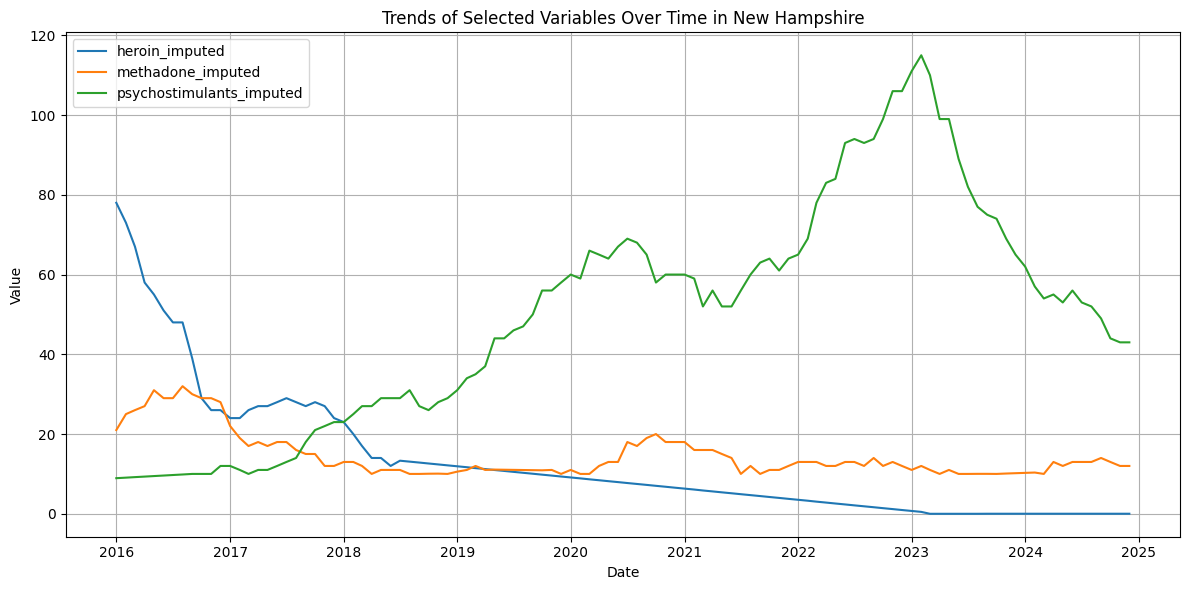

In [737]:
import matplotlib.pyplot as plt

# Plot the selected variables
plt.figure(figsize=(12, 6))
for column in ['heroin_imputed', 'methadone_imputed', 'psychostimulants_imputed']:
    plt.plot(df_nh['Date'], df_nh[column], label=column)

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends of Selected Variables Over Time in New Hampshire')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

https://mm.nh.gov/files/uploads/doj/remote-docs/2019-drug-death-data.pdf for 2019

Might seams strange but I validated the answer and actually in NH apparently people don't die by Heroin

https://pmc.ncbi.nlm.nih.gov/articles/PMC7516293/ for 2020

Keyword: States with substantial reductions included New Hampshire (−57%)

https://www.kff.org/statedata/mental-health-and-substance-use-state-fact-sheets/new-hampshire/#:~:text=In%202021%2C%20there%20were%20382,in%20the%20country%20in%202021. Here it specificy Heroin was a phase of early 10s


In [738]:
# only for df where State == 'NH'
df.loc[df['State'] == 'NH', 'heroin'] = df_nh['heroin_imputed']
df.loc[df['State'] == 'NH', 'methadone'] = df_nh['methadone_imputed']
df.loc[df['State'] == 'NH', 'psychostimulants'] = df_nh['psychostimulants_imputed']

df.loc[df['State'] == 'MA', 'heroin'] = df_ma['heroin']
df.loc[df['State'] == 'MA', 'methadone'] = df_ma['methadone']
df.loc[df['State'] == 'MA', 'psychostimulants'] = df_ma['psychostimulants']


In [739]:
outcomes = {
    "opioids_all": "opioids_all", # outcome principale
    "synthetic_opioids": "synthetic_opioids", # fentanyl e simili
    "cocaine": "cocaine",
    "natural_semi_synthetic": "natural_semi_synthetic",
    "natural_incl_methadone": "natural_incl_methadone",
    "natural_synthetic_incl_methadone": "natural_synthetic_incl_methadone",
    "heroin": "heroin",
    "methadone": "methadone",
    "psychostimulants": "psychostimulants",
}
#df.drop(columns=['heroin','methadone','psychostimulants'], inplace=True)

for key, column in outcomes.items():
    df[column] = (df[column] / df['Population']) * 100

In [740]:
df.rename(columns={'MJ Arrests (%)': 'MJ_Arrests', 'Agencies (%)': 'Agencies','Minimum Wage': 'Minimum_Wage','Unemployment Rate':'Unemployment_Rate'}, inplace=True)

covariates = [
    'Population',
    'Minimum_Wage',
    'Unemployment_Rate',
    'MJ_Arrests',
    'Agencies',
    'GDP_per_capita',
    'Arrests_per_100k',
    'Possession_per_100k',
    'Sales_per_100k',
    'Voters_percentage',
    'Democratic_percentage',
    'Republican_percentage',
    'Undeclared_percentage',
    'Covid_t'
]
assert df[covariates].isna().sum().sum() == 0
# No Nans

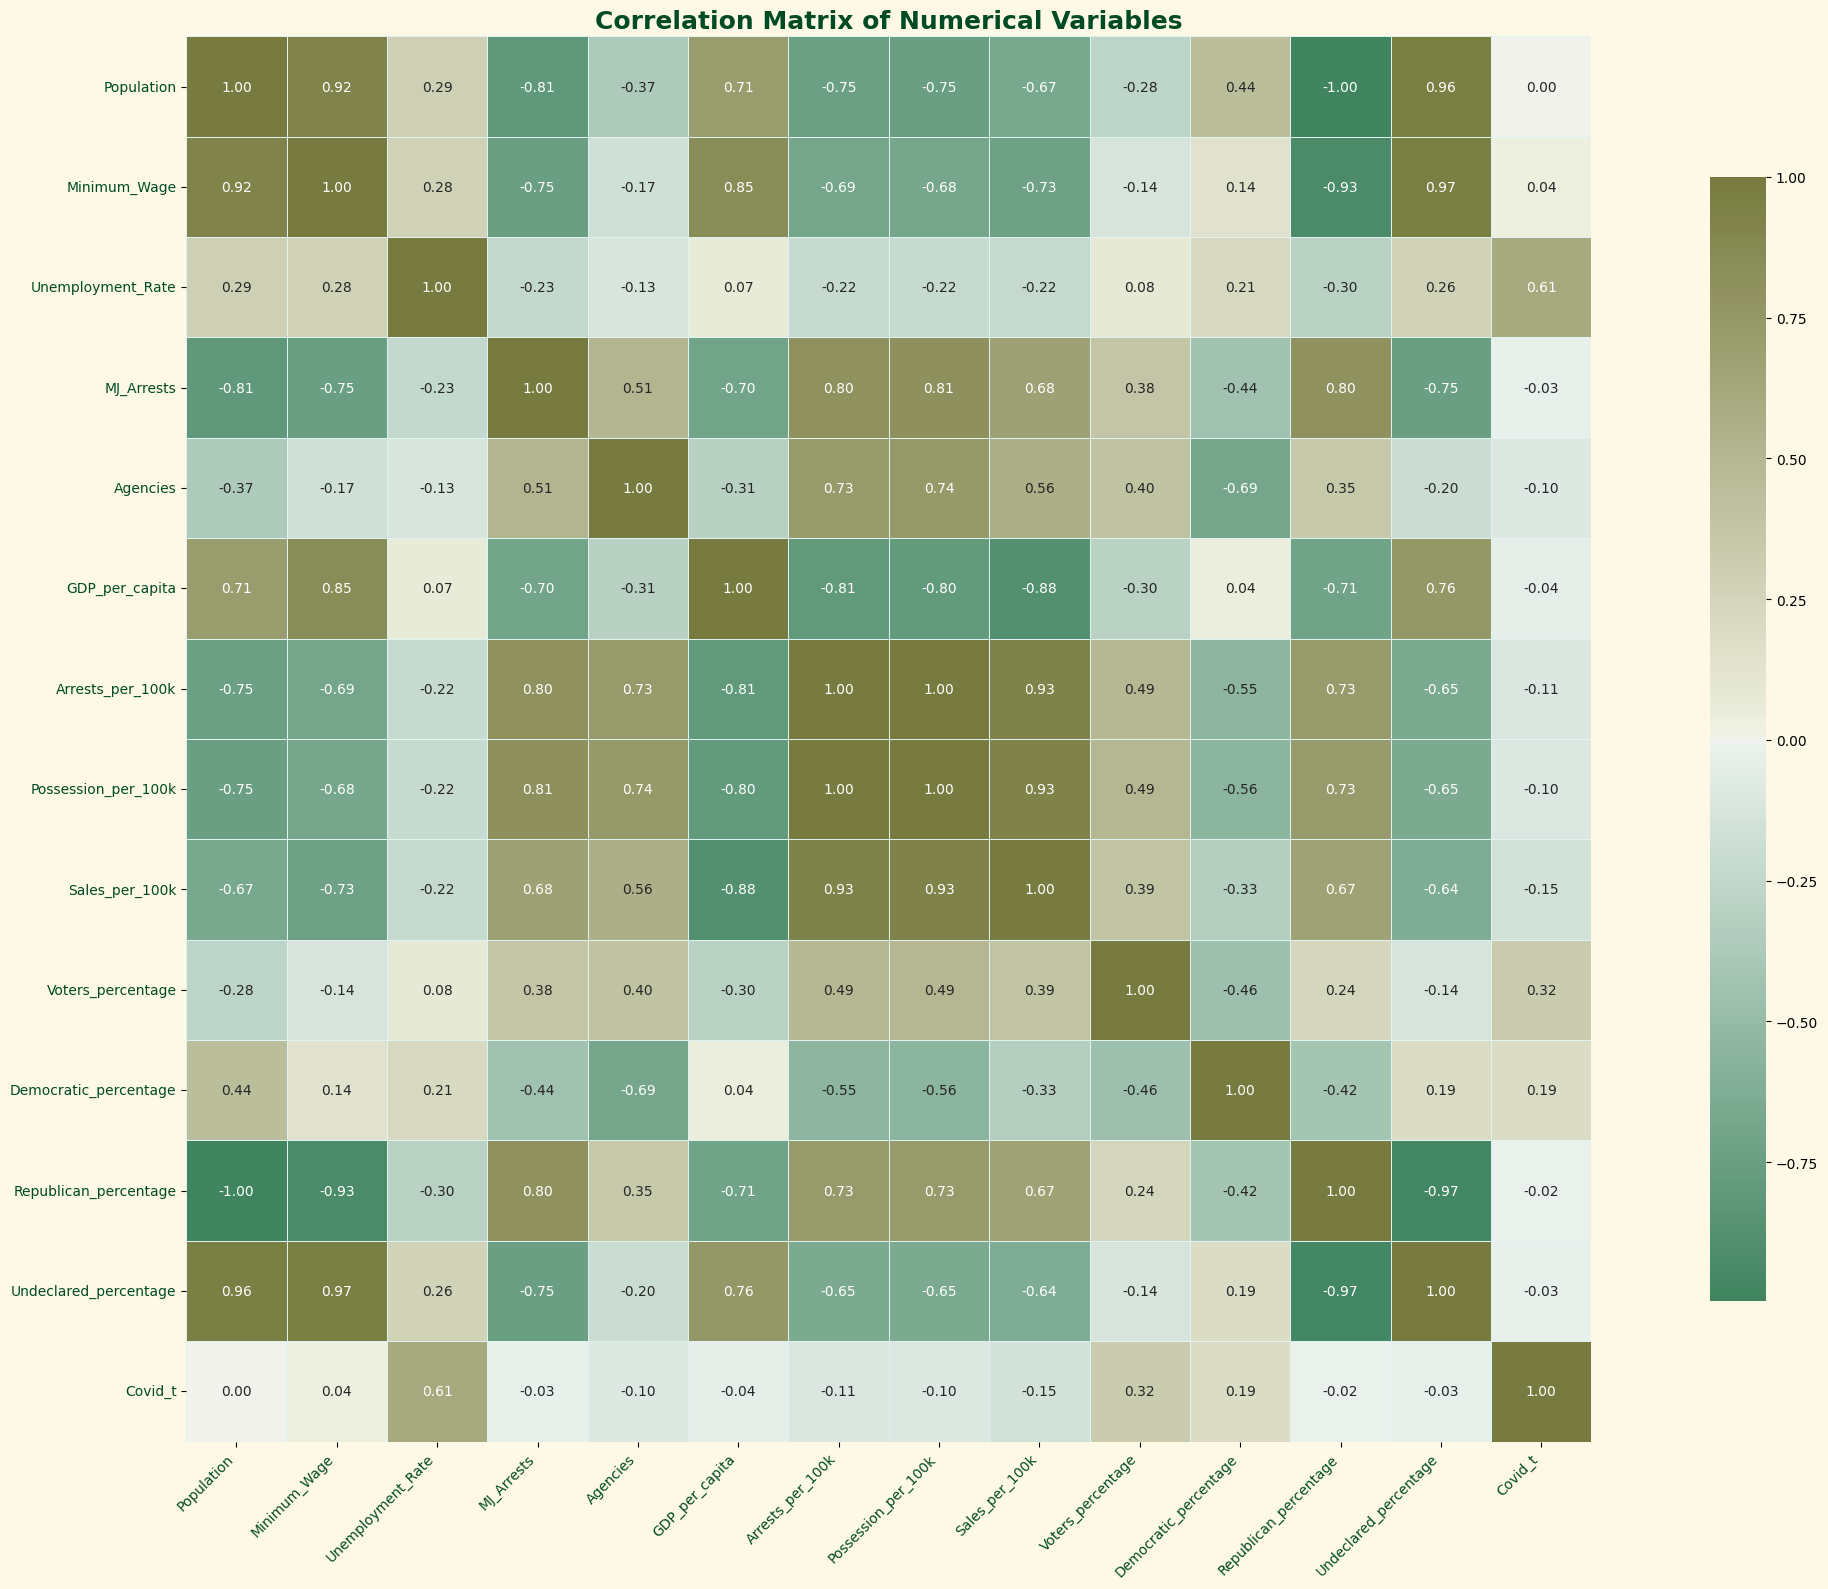

In [741]:
corr_matrix = df[covariates].corr()
marijuana_cmap = sns.diverging_palette(145, 90, s=70, l=50, as_cmap=True)  # dark green to light green/yellow

# Create the plot
plt.figure(figsize=(24, 16))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=marijuana_cmap,
    square=True,
    linewidths=0.5,
    linecolor='#e0f2f1',
    cbar_kws={"shrink": .8}
)

# Style background and labels
ax.set_facecolor('#fffde7')  # light yellow background
plt.gcf().patch.set_facecolor('#fef9e7')  # soft beige full background
plt.title("Correlation Matrix of Numerical Variables", fontsize=18, weight='bold', color='#004B23')  # dark green title
plt.xticks(rotation=45, ha='right', fontsize=10, color='#004B23')
plt.yticks(rotation=0, fontsize=10, color='#004B23')

plt.tight_layout()
plt.show()


In [742]:
# select corr values > 0.95
high_corr_vars = corr_matrix[(corr_matrix > 0.90)].stack().index.tolist()
# exlude the diagonal
high_corr_vars = [(x, y) for x, y in high_corr_vars if x != y]
# when u print print also the value
for x, y in high_corr_vars:
    print(f"Correlation between {x} and {y}: {corr_matrix.loc[x, y]:.2f}")

Correlation between Population and Minimum_Wage: 0.92
Correlation between Population and Undeclared_percentage: 0.96
Correlation between Minimum_Wage and Population: 0.92
Correlation between Minimum_Wage and Undeclared_percentage: 0.97
Correlation between Arrests_per_100k and Possession_per_100k: 1.00
Correlation between Arrests_per_100k and Sales_per_100k: 0.93
Correlation between Possession_per_100k and Arrests_per_100k: 1.00
Correlation between Possession_per_100k and Sales_per_100k: 0.93
Correlation between Sales_per_100k and Arrests_per_100k: 0.93
Correlation between Sales_per_100k and Possession_per_100k: 0.93
Correlation between Undeclared_percentage and Population: 0.96
Correlation between Undeclared_percentage and Minimum_Wage: 0.97


In [ ]:
df.drop(columns=["Population","Undeclared_percentage","Sales_per_100k","Possession_per_100k","Agencies"], inplace=True)

In [744]:

covariates = [
    #'Population',
    'Minimum_Wage',
    'Unemployment_Rate',
    'MJ_Arrests',
    #'Agencies',
    'GDP_per_capita',
    'Arrests_per_100k',
    #'Possession_per_100k',
    #'Sales_per_100k',
    'Voters_percentage',
    'Democratic_percentage',
    'Republican_percentage',
    #'Undeclared_percentage',
    'Covid_t'
]
assert df[covariates].isna().sum().sum() == 0
# No Nans

###  Modello Difference-in-Differences con covariate e effetti fissi (Standard)

Il modello stimato è il seguente:

$$
y_{st} = \alpha + \delta \cdot \text{treated\_post}_{st} + \beta^\top X_{st} + \gamma_s + \lambda_t + \epsilon_{st}
$$

Dove:

- $y_{st}$ è il **tasso mensile di decessi per overdose** nello stato $s$ al tempo $t$, espresso come numero di decessi per **100.000 abitanti**.

- $\gamma_s$ è un **effetto fisso per ciascuno stato**. Cattura tutte le caratteristiche strutturali e invarianti nel tempo, come:
  - composizione demografica,
  - cultura e politiche storiche,
  - accesso al sistema sanitario.
  
  Questo termine assicura che il confronto tra stati avvenga **rispetto alla propria baseline pre-trattamento**, evitando confondenti stabili.

- $\lambda_t$ è un **effetto fisso temporale**, che varia mese per mese. Include una dummy per ogni combinazione mese–anno (es. "Gennaio 2015", "Febbraio 2015", ..., "Dicembre 2024"). Serve a catturare **shock temporali comuni** a tutti gli stati, come:
  - la diffusione del fentanyl tra il 2016 e il 2017,
  - l’emergere della pandemia COVID-19,
  - riforme federali o linee guida CDC.

- $\text{treated\_post}_{st}$ è la **variabile chiave DiD**, ottenuta come interazione tra:
  - $\text{treated}_s = 1$ se lo stato è il **Massachusetts** (gruppo trattato), 0 se è il **New Hampshire** (gruppo di controllo);
  - $\text{post}_t = 1$ a partire da **ottobre 2018** (data di apertura dei negozi di marijuana), 0 altrimenti.

  L’interazione vale 1 **solo per Massachusetts dopo la policy**. Il coefficiente $\delta$ misura l’**effetto causale medio** della legalizzazione e apertura dei negozi sulla variabile $y_{st}$, dopo aver controllato per trend e differenze sistematiche.

- $X_{st}$ è un **vettore di covariate time-varying** che possono influenzare direttamente $y_{st}$. Nel tuo caso include, ad esempio:
  - tasso di disoccupazione,
  - salario minimo,
  - tasso di arresti per droga,
  - composizione elettorale,
  - PIL pro capite, ecc.

- $\epsilon_{st}$ è il **termine di errore**, che raccoglie la variazione residua non spiegata dal modello.


### Obiettivo del Modello

Stimare il parametro $\delta$, che rappresenta:

La variazione media nel tasso di overdose nel Massachusetts dopo la legalizzazione della marijuana (e apertura dei negozi), rispetto a New Hampshire nello stesso periodo, al netto:

- delle differenze strutturali tra i due stati (catturate da $\gamma_s$)
- delle tendenze temporali comuni (catturate da $\lambda_t$)
- delle altre variabili osservabili X_{st}

| Caso                        | Interpretazione                                                     |
| --------------------------- | ------------------------------------------------------------------- |
| `δ < 0` e significativo     | La policy ha **ridotto** il tasso di overdose in MA rispetto a NH   |
| `δ > 0` e significativo     | La policy ha **aumentato** il tasso di overdose in MA rispetto a NH |
| `δ ≈ 0` o non significativo | Nessun effetto identificabile della policy                          |

Ancora piu' chiaro:

Data la struttura pre–post–trattamento, e controllando per le differenze sistematiche tra stati e per gli shock comuni nel tempo, la differenza media nei tassi di overdose nel Massachusetts dopo l’apertura dei negozi di marijuana è statisticamente diversa da quella del New Hampshire?

La chiave dell’identificazione è l’assunzione di trend paralleli:

In assenza della policy, il Massachusetts e il New Hampshire avrebbero avuto andamenti simili nel tempo nei tassi di overdose. (abbiamo già verificato visivamente nei plots)

In [745]:
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.iolib.summary2 import summary_col

results = []

for label, y in outcomes.items():
    formula = f"Q('{y}') ~ treated_post + {' + '.join(covariates)} + C(State) + C(Date)"
    
    model = smf.ols(formula=formula, data=df).fit(cov_type="HC1")  # robust SE
    
    # Estrai i risultati per treated_post
    coef = model.params.get("treated_post", float("nan"))
    std_err = model.bse.get("treated_post", float("nan"))
    p_val = model.pvalues.get("treated_post", float("nan"))
    
    results.append({
        "Outcome": y,
        "Coef. (treated_post)": coef,
        "Std. Err.": std_err,
        "p-value": p_val,
        "Significant (p < 0.05)": "✅" if p_val < 0.05 else "❌"
    })
# Define a mapping from old column names to nicer labels
label_map = {
    "psychostimulants_imputed": "Psychostimulants",
    "methadone_imputed": "Methadone",
    "heroin_imputed": "Heroin",
    "natural_synthetic_incl_methadone": "Natural & Synthetic",
    "natural_incl_methadone": "Natural Opioids",
    "natural_semi_synthetic": "Natural/Semi-synthetic",
    "cocaine": "Cocaine",
    "synthetic_opioids": "Synthetic Opioids",
    "opioids_all": "All Opioids"
}
results_df = pd.DataFrame(results)
# Apply the mapping to rename the Outcome column
results_df["Outcome"] = results_df["Outcome"].replace(label_map)
results_df

,Outcome,Coef. (treated_post),Std. Err.,p-value,Significant (p < 0.05)
0,All Opioids,1.838523,0.982544,0.061319,❌
1,Synthetic Opioids,2.191480,1.034860,0.034204,✅
2,Cocaine,-2.920001,0.661099,0.000010,✅
3,Natural/Semi-synthetic,0.428268,0.371697,0.249240,❌
4,Natural Opioids,0.060339,0.455958,0.894720,❌
5,Natural & Synthetic,2.411190,1.016665,0.017708,✅
6,heroin,0.725359,0.271984,0.007655,✅
7,methadone,-0.288440,0.214709,0.179144,❌
8,psychostimulants,-0.661729,0.432241,0.125788,❌


Si legge come:
Dopo la legalizzazione, il Massachusetts ha avuto [Coef. (treated_post).value] morti in [Coef. (treated_post).value.segno]. per 100k abitanti (al mese) rispetto al New Hampshire.

Per le ultime 3, robabilmente ci sono valori costanti o zero-variance nella variabile → il modello non riesce a stimare la varianza → collinearity o variabili non informate.
Quando usare questo modello?

- Quando ti interessa una stima semplice e robusta dell’effetto complessivo.

- Quando l’effetto della policy è plausibilmente costante nel tempo post-trattamento.

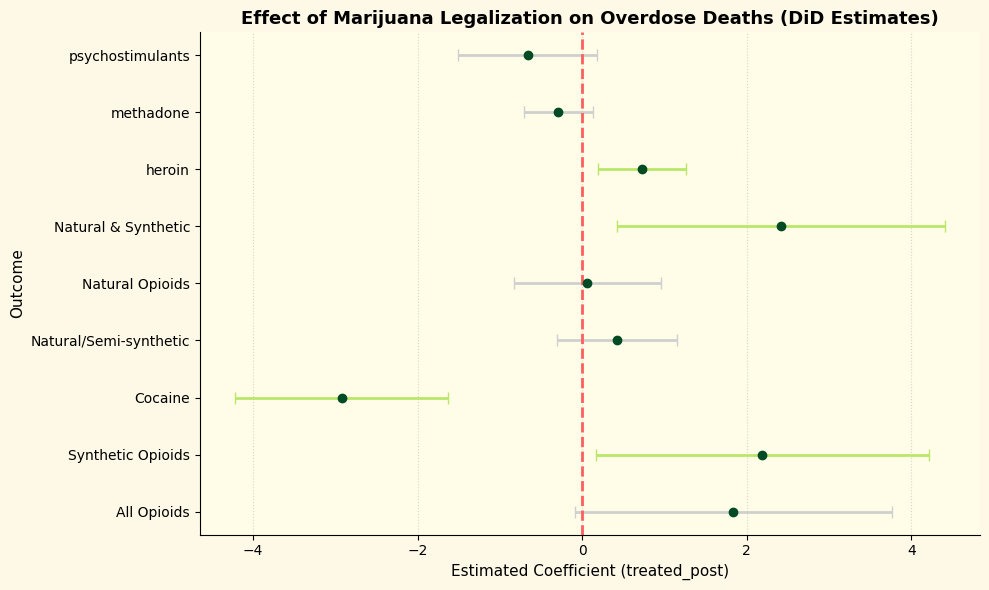

In [746]:
import matplotlib.pyplot as plt

# Set custom color theme
background_color = "#fef9e7"       # soft beige
axes_color = "#fffde7"             # plot area
point_color = "#004B23"            # dark green
highlight_color = "#B9E769"        # light green
neutral_color = "#cfcfcf"          # gray for non-sig
vline_color = "#ff5e5e"            # soft red

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(axes_color)

# Plot error bars
for i, row in results_df.iterrows():
    ax.errorbar(
        row["Coef. (treated_post)"],
        row["Outcome"],
        xerr=1.96 * row["Std. Err."],
        fmt='o',
        color=point_color,
        ecolor=highlight_color if row["Significant (p < 0.05)"] == "✅" else neutral_color,
        capsize=4,
        elinewidth=2,
        markersize=6
    )

# Add vertical line at 0 (no effect)
ax.axvline(0, color=vline_color, linestyle='--', linewidth=2)

# Labels and styling
ax.set_title("Effect of Marijuana Legalization on Overdose Deaths (DiD Estimates)", fontsize=13, fontweight='bold')
ax.set_xlabel("Estimated Coefficient (treated_post)", fontsize=11)
ax.set_ylabel("Outcome", fontsize=11)
ax.grid(axis='x', linestyle=':', alpha=0.5)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


barre di errore (± 1.96 × std err)

La linea rossa verticale (x=0) rappresenta l’ipotesi nulla (nessun effetto).

We use Logit to analyze the possibility that the death by oppiods raise month by month

In [747]:
df = df.sort_values(["State", "Date"])  # Sort by state and date
df["opioids_up"] = df.groupby("State")["opioids_all"].diff().gt(0).astype(int)  # Calculate by state

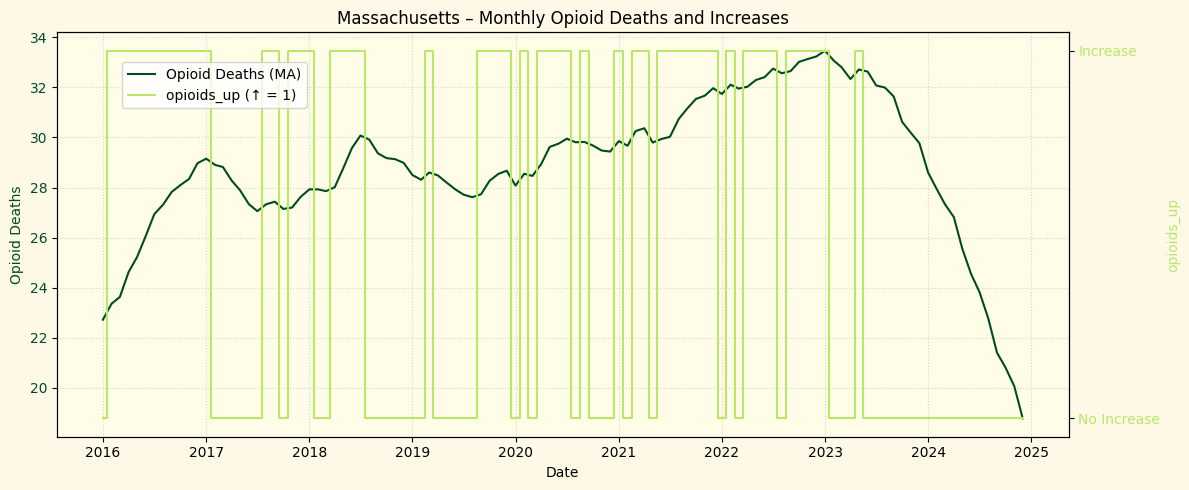

In [748]:
import matplotlib.pyplot as plt

# === COLOR THEME ===
background_color = "#fef9e7"
axes_color = "#fffde7"
line_color = "#004B23"         # dark green
step_color = "#B9E769"         # light green
vline_color = "#ff5e5e"

# === PREPARE DATA ===
ma_df = df[df["State"] == "MA"].copy().sort_values("Date")
ma_df["opioids_up"] = ma_df["opioids_all"].diff().gt(0).astype(int)

# === PLOT ===
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor(background_color)
ax1.set_facecolor(axes_color)

# Line plot for actual deaths
ax1.plot(ma_df["Date"], ma_df["opioids_all"], color=line_color, label="Opioid Deaths (MA)")
ax1.set_ylabel("Opioid Deaths", color=line_color)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.set_xlabel("Date")
ax1.set_title("Massachusetts – Monthly Opioid Deaths and Increases")

# Secondary axis for binary step
ax2 = ax1.twinx()
ax2.step(ma_df["Date"], ma_df["opioids_up"], where='mid', color=step_color, label="opioids_up (↑ = 1)")
ax2.set_ylabel("opioids_up", color=step_color)
ax2.tick_params(axis='y', labelcolor=step_color)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["No Increase", "Increase"])

# Decorations
ax1.grid(True, linestyle=":", alpha=0.5)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.88))
plt.tight_layout()
plt.show()


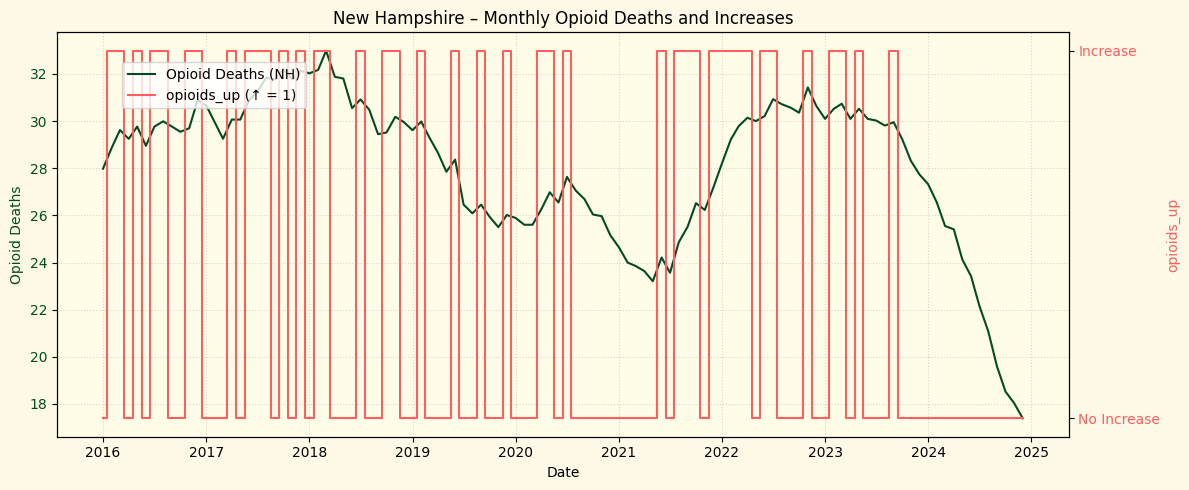

In [749]:
# === PREPARE DATA ===
nh_df = df[df["State"] == "NH"].copy().sort_values("Date")
nh_df["opioids_up"] = nh_df["opioids_all"].diff().gt(0).astype(int)

# === PLOT ===
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor(background_color)
ax1.set_facecolor(axes_color)

# Line plot for actual deaths
ax1.plot(nh_df["Date"], nh_df["opioids_all"], color=line_color, label="Opioid Deaths (NH)")
ax1.set_ylabel("Opioid Deaths", color=line_color)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.set_xlabel("Date")
ax1.set_title("New Hampshire – Monthly Opioid Deaths and Increases")

# Secondary axis for binary step
ax2 = ax1.twinx()
ax2.step(nh_df["Date"], nh_df["opioids_up"], where='mid', color="#ff5e5e", label="opioids_up (↑ = 1)")
ax2.set_ylabel("opioids_up", color="#ff5e5e")
ax2.tick_params(axis='y', labelcolor="#ff5e5e")
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["No Increase", "Increase"])

# Decorations
ax1.grid(True, linestyle=":", alpha=0.5)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.88))
plt.tight_layout()
plt.show()


$$
1  \text{ if deaths in } s,t \text{ increased vs. } t{-}1 \
0  \text{ otherwise}
$$

In [750]:
import statsmodels.formula.api as smf

logit_model  = smf.logit("opioids_up ~ treated_post + " + " + ".join(covariates) + " + C(State)", data=df)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.589131
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             opioids_up   No. Observations:                  216
Model:                          Logit   Df Residuals:                      204
Method:                           MLE   Df Model:                           11
Date:                Thu, 22 May 2025   Pseudo R-squ.:                  0.1396
Time:                        14:39:45   Log-Likelihood:                -127.25
converged:                       True   LL-Null:                       -147.90
Covariance Type:            nonrobust   LLR p-value:                 2.144e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -13.7154     11.525     -1.190      0.234     -36.303       8.

Pseudo R² = 0.14 → buona spiegazione in contesto binario

Log-Likelihood migliorato rispetto al modello nullo

LLR p-value < 0.001 → il modello complessivo è significativo



In [751]:
result.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:             opioids_up
Method:                          dydx
At:                           overall
=========================================================================================
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(State)[T.NH]            2.5322      1.917      1.321      0.187      -1.226       6.290
treated_post             -0.1698      0.168     -1.010      0.312      -0.499       0.160
Minimum_Wage              0.0224      0.105      0.214      0.831      -0.183       0.228
Unemployment_Rate         0.0310      0.023      1.336      0.182      -0.014       0.076
MJ_Arrests                0.0035      0.004      0.957      0.338      -0.004       0.011
GDP_per_capita         1.408e-05   1.54e-05      0.917      0.359    -1.6e-05    4.42e-05
Arrests_per_100k          0.0054      0.002      2.598      0.009       0.001       0.010
Voters_percentage     -2.755e-05   1.22e-05     -2.249      0.025   -5.16e-05   -3.54e-06
Democratic_percentage     0.1351      0.047      2.897      0.004       0.044       0.227
Republican_percentage    -0.1351      0.097     -1.387      0.165      -0.326       0.056
Covid_t                   0.0816      0.126      0.647      0.518      -0.166       0.329
=========================================================================================
"""

Il modello stima l’effetto marginale di ciascuna variabile esplicativa sulla probabilità che i decessi aumentino (cioè che opioids_up = 1). L’interpretazione è in termini di variazione percentuale assoluta nella probabilità.



| Variabile        | Effetto marginale | Significativo? | Interpretazione                                                                                                                                          |
| ---------------- | ----------------- | -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `treated_post`   | **–0.170**        | ❌ (p = 0.312)  | Dopo la legalizzazione, la probabilità di un aumento mensile nei decessi da oppioidi **diminuisce del 17%**, ma **non è statisticamente significativo**. |
| `C(State)[T.NH]` | +2.53             | ❌ (p = 0.187)  | NH ha una probabilità **molto più alta** di aumento dei decessi rispetto al MA, ma l’intervallo è ampio e **non significativo**.                         |


| Variabile                 | Effetto marginale | Significativo? | Interpretazione                                                                                                                                                                               |
| ------------------------- | ----------------- | -------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `Arrests_per_100k`        | **+0.0054**       | ✅ (p = 0.009)  | Un aumento di 1 unità negli arresti ogni 100k abitanti è associato a un **+0.54%** nella probabilità di aumento dei decessi. Segnala un possibile clima repressivo legato a stress o rischio. |
| `Voters_percentage`       | **–0.000028**     | ✅ (p = 0.025)  | Un aumento dell’1% nella percentuale di votanti è associato a **–0.0028%** nella probabilità: sembra piccolo ma indica che **maggiore partecipazione civica** è legata a minori aumenti.      |
| `Democratic_percentage`   | **+0.135**        | ✅ (p = 0.004)  | Gli stati con più elettori Democratici mostrano **+13.5%** di probabilità di crescita dei decessi. Potrebbe riflettere **aree urbane, più colpite**, o **confounding non osservati**.         |
| `Republican_percentage`   | –0.135            | ❌              | Effetto simmetrico ma **non significativo**.                                                                                                                                                  |
| `Unemployment_Rate`       | +0.031            | ❌              | Segnale debole che la disoccupazione aumenti il rischio.                                                                                                                                      |
| `MJ_Arrests`              | +0.0035           | ❌              | Nessun impatto significativo.                                                                                                                                                                 |
| `GDP_per_capita`          | +0.000014         | ❌              | Effetto trascurabile e statisticamente nullo.                                                                                                                                                 |
| `Minimum_Wage`            | +0.0224           | ❌              | Nessun impatto chiaro osservato.                                                                                                                                                              |
| `Covid_t` (periodo Covid) | +0.0816           | ❌              | L’effetto positivo del periodo Covid sulla crescita dei decessi **non è significativo**, ma coerente con la crisi.                                                                            |


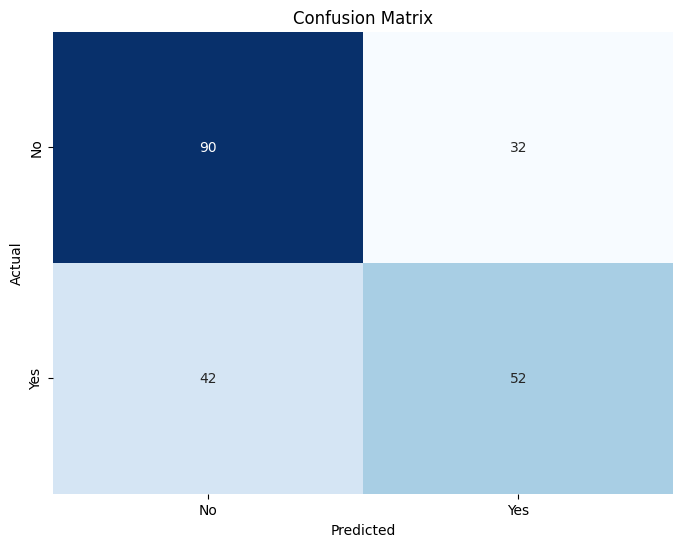

In [752]:
from sklearn.metrics import roc_auc_score, confusion_matrix
y_true = df["opioids_up"]
df["pred_prob"] = result.predict()
y_pred = df["pred_prob"]
roc_auc_score(y_true, y_pred)
# confusion matrix
cm = confusion_matrix(y_true, y_pred.round())
import seaborn as sns
confusion_matrix_df = pd.DataFrame(cm, index=["No", "Yes"], columns=["No", "Yes"])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 600x400 with 0 Axes>

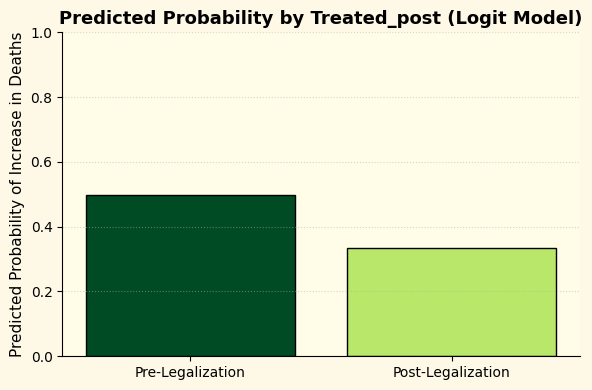

In [753]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. Convert logit coefficients to odds ratios
odds_ratios = np.exp(result.params)
conf_int = np.exp(result.conf_int())
odds_ratios_df = pd.DataFrame({
    "Odds Ratio": odds_ratios,
    "CI Lower": conf_int[0],
    "CI Upper": conf_int[1]
})

# 2. Predicted probabilities for treated_post = 0 and 1
df_predict = df.copy()
df_predict['treated_post'] = 0
pred_0 = result.predict(df_predict).mean()

df_predict['treated_post'] = 1
pred_1 = result.predict(df_predict).mean()

# Set custom color theme for marijuana-themed plot
background_color = "#fef9e7"       # soft beige
axes_color = "#fffde7"             # plot area
bar_colors = ["#004B23", "#B9E769"]  # dark green and light green

# Create the plot
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(axes_color)

# Plot bars
ax.bar(
    ["Pre-Legalization", "Post-Legalization"],
    [pred_0, pred_1],
    color=bar_colors,
    edgecolor="black"
)

# Add labels and title
ax.set_ylabel("Predicted Probability of Increase in Deaths", fontsize=11)
ax.set_title("Predicted Probability by Treated_post (Logit Model)", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle=':', alpha=0.5)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

This suggests a potential reduction in the likelihood of month-over-month increases in opioid deaths after legalization

In [754]:
probit_model = smf.probit("opioids_up ~ treated_post + " + " + ".join(covariates) + " + C(State)", data=df)
probit_result = probit_model.fit()
print(probit_result.summary())


Optimization terminated successfully.
         Current function value: 0.587863
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:             opioids_up   No. Observations:                  216
Model:                         Probit   Df Residuals:                      204
Method:                           MLE   Df Model:                           11
Date:                Thu, 22 May 2025   Pseudo R-squ.:                  0.1415
Time:                        14:39:45   Log-Likelihood:                -126.98
converged:                       True   LL-Null:                       -147.90
Covariance Type:            nonrobust   LLR p-value:                 1.724e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -8.5202      6.889     -1.237      0.216     -22.023       4.

In [755]:
# Effetti marginali
mfx_probit = probit_result.get_margeff()
print(mfx_probit.summary())


       Probit Marginal Effects       
Dep. Variable:             opioids_up
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(State)[T.NH]            2.4532      1.934      1.268      0.205      -1.338       6.245
treated_post             -0.1647      0.171     -0.963      0.336      -0.500       0.171
Minimum_Wage              0.0208      0.105      0.198      0.843      -0.186       0.227
Unemployment_Rate         0.0318      0.023      1.368      0.171      -0.014       0.077
MJ_Arrests                0.0033      0.004      0.921      0.357      -0.004       0.010
GDP_per_capita         1.406e-05   1.53e-05      0.919      0.358   -1.59e-05    4.41e-05
Arrests_per_100k          0.0054      0.002      2.595      0.009       0.001       0.010
Voters_percentage     -2.714e-05   1.2

Probit models assume a normal distribution of errors, while Logit assumes a logistic (fatter tails). This affects the shape of predicted probabilities but not the direction of effects. In practice:

Probit is often used in economics (especially structural models),

Logit is more common in social sciences.

Since your marginal effects and significance levels are consistent across models, you’ve added credibility to your results!


In [756]:
df["IV_policy"] = ((df["State"] == "MA") & (df["Date"] >= "2018-01-01")).astype(int)
first_stage = smf.ols("treated_post ~ IV_policy + " + " + ".join(covariates) + " + C(State)", data=df).fit()
df["treated_post_hat"] = first_stage.fittedvalues
second_stage = smf.logit("opioids_up ~ treated_post_hat + " + " + ".join(covariates) + " + C(State)", data=df).fit()
print(second_stage.summary())


Optimization terminated successfully.
         Current function value: 0.588628
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             opioids_up   No. Observations:                  216
Model:                          Logit   Df Residuals:                      204
Method:                           MLE   Df Model:                           11
Date:                Thu, 22 May 2025   Pseudo R-squ.:                  0.1403
Time:                        14:39:45   Log-Likelihood:                -127.14
converged:                       True   LL-Null:                       -147.90
Covariance Type:            nonrobust   LLR p-value:                 1.967e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -14.6160     11.634     -1.256      0.209     -37.418       8.

In [757]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Assuming `iv_logit` is your fitted model (after second stage)
iv_marginal = second_stage.get_margeff(at="overall")
print(iv_marginal.summary())


        Logit Marginal Effects       
Dep. Variable:             opioids_up
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(State)[T.NH]            2.5435      1.922      1.324      0.186      -1.223       6.310
treated_post_hat         -0.3538      0.317     -1.116      0.264      -0.975       0.267
Minimum_Wage              0.0689      0.125      0.550      0.583      -0.177       0.314
Unemployment_Rate         0.0302      0.023      1.294      0.196      -0.016       0.076
MJ_Arrests                0.0048      0.004      1.150      0.250      -0.003       0.013
GDP_per_capita         1.305e-05   1.55e-05      0.840      0.401   -1.74e-05    4.35e-05
Arrests_per_100k          0.0053      0.002      2.520      0.012       0.001       0.009
Voters_percentage     -3.035e-05   1.2

In [758]:
import statsmodels.api as sm

# Generate an F-test for IV_policy only
f_test = first_stage.f_test("IV_policy = 0")
print(f_test)


<F test: F=79.43689299855866, p=2.8137125012259855e-16, df_denom=204, df_num=1>


In [759]:
from linearmodels.iv import IV2SLS

iv_model = IV2SLS.from_formula(
    "opioids_up ~ 1 + " + " + ".join(covariates) + " + C(State) + [treated_post ~ IV_policy]",
    data=df
).fit(cov_type="robust")
print(iv_model.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:             opioids_up   R-squared:                      0.1607
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1155
No. Observations:                 216   F-statistic:                    130.89
Date:                Thu, May 22 2025   P-value (F-stat)                0.0000
Time:                        14:39:45   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                -2.2362     2.1924    -1.0200     0.3077     -6.5333      2.0609
Minimum_

### event study per stimare l’effetto mese per mese (pre/post) (Dinamico)

Ora il modello è il seguente:

$$
y_{st} = \alpha + \sum_{k \neq -1} \delta_k \cdot D_k + \beta' X_{st} + \gamma_s + \varepsilon_{st}
$$

dove a differenza di prima abbiamo:

- $D_k$ sono variabili dummy che indicano se l’osservazione corrisponde a k mesi prima o dopo la policy (escludendo k = -1 ), che funge da periodo base).
- Inoltre abbiamo rimosso la variabile temporale $\lambda_t$ perchè aggiungendo queste dummies avremmo avuto due variabili perfettamente correlate quindi il nostro modello assumeva coefficienti infiniti

L'event study nel nostro caso dice che l’effetto esiste ma non è costante, quindi il DiD standard sottintende una media su un effetto non costante.

Quando usarlo:

. Quando vuoi testare esplicitamente la parallel trends assumption (guardando se $\delta_k$≈0 prima della policy).

- Quando sospetti un effetto che varia nel tempo (es. effetto temporaneo o ritardato).

- Quando vuoi mostrare la dinamica del trattamento, non solo il valore medio.

In [760]:
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# -------------------------
# 1. DATA: Calcolo mesi relativi alla policy
# -------------------------

policy_date = pd.to_datetime("2018-10-01")  # data della legalizzazione operativa

df["months_since_treatment"] = df["Date"].apply(
    lambda x: (relativedelta(x, policy_date).years * 12 + relativedelta(x, policy_date).months)
)

# Assegna NaN agli stati di controllo per evitare errori nei dummies
df.loc[df["treated"] == 0, "months_since_treatment"] = np.nan


In [761]:
# -------------------------
# 2. CREAZIONE DUMMIES rel_month_k
# -------------------------

dummy_cols = []

for k in range(-24, 25):
    if k == -1:  # mese di riferimento (baseline)
        continue
    col = f"rel_month_m{abs(k)}" if k < 0 else f"rel_month_{k}"
    df[col] = ((df["months_since_treatment"] == k) & (df["treated"] == 1)).astype(int)
    dummy_cols.append(col)


In [762]:
# -------------------------
# 3. MODELLO EVENT STUDY
# -------------------------

outcome = "opioids_all" 

# Assicurati che tutte le covariate siano disponibili nel dataset
formula = f"{outcome} ~ {' + '.join(dummy_cols)} + {' + '.join(covariates)} + C(State)"

model_event = smf.ols(formula=formula, data=df).fit(cov_type="HC1")



In [763]:
# -------------------------
# 4. ESTRAZIONE COEFFICIENTI E CI
# -------------------------

event_results = []

for col in dummy_cols:
    k_str = col.replace("rel_month_", "")
    k = -int(k_str[1:]) if k_str.startswith("m") else int(k_str)
    
    coef = model_event.params.get(col, np.nan)
    se = model_event.bse.get(col, np.nan)
    
    event_results.append({
        "k": k,
        "coef": coef,
        "lower": coef - 1.96 * se,
        "upper": coef + 1.96 * se
    })

event_df = pd.DataFrame(event_results).sort_values("k")


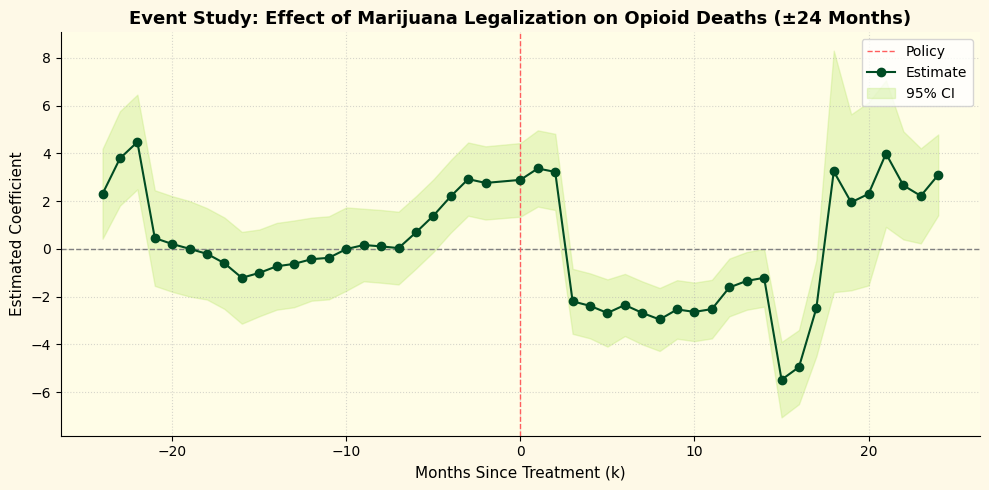

In [764]:
import matplotlib.pyplot as plt

# Define custom theme colors
background_color = "#fef9e7"      # light beige
plot_area_color = "#fffde7"       # very soft yellow
line_color = "#004B23"            # deep green for main line
ci_color = "#B9E769"              # light green for CI band
policy_line_color = "#ff5e5e"     # soft red for policy line

# Filter the event window
event_df_window = event_df[(event_df["k"] >= -24) & (event_df["k"] <= 24)].copy()

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(plot_area_color)

# Horizontal zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# Vertical policy implementation line at k=0
ax.axvline(0, color=policy_line_color, linestyle="--", linewidth=1, label="Policy")

# Estimate line
ax.plot(event_df_window["k"], event_df_window["coef"], label="Estimate", color=line_color, marker='o')

# Confidence band
ax.fill_between(
    event_df_window["k"],
    event_df_window["lower"],
    event_df_window["upper"],
    color=ci_color,
    alpha=0.3,
    label="95% CI"
)

# Labels and style
ax.set_title("Event Study: Effect of Marijuana Legalization on Opioid Deaths (±24 Months)", fontsize=13, fontweight="bold")
ax.set_xlabel("Months Since Treatment (k)", fontsize=11)
ax.set_ylabel("Estimated Coefficient", fontsize=11)
ax.grid(True, linestyle=":", alpha=0.5)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()



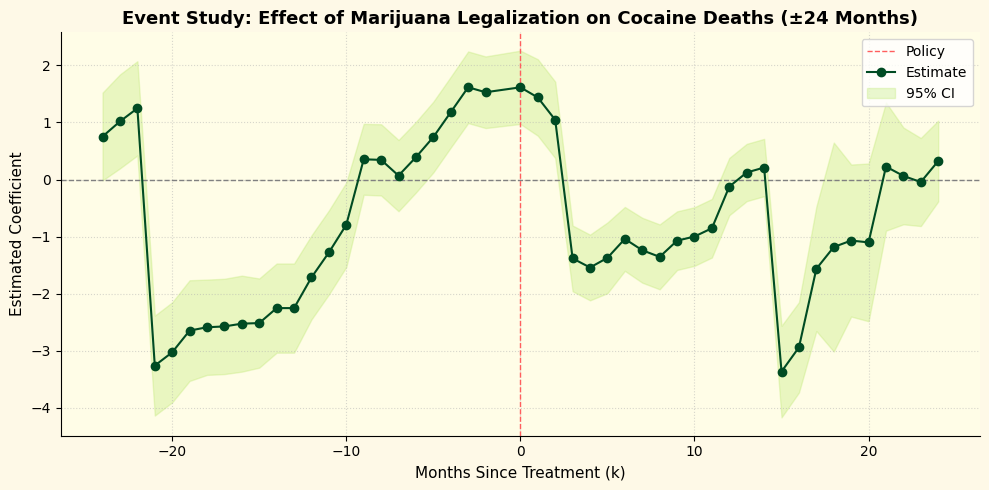

In [765]:
outcome = "cocaine" 

# Assicurati che tutte le covariate siano disponibili nel dataset
formula = f"{outcome} ~ {' + '.join(dummy_cols)} + {' + '.join(covariates)} + C(State)"

model_event = smf.ols(formula=formula, data=df).fit(cov_type="HC1")
# -------------------------
# 4. ESTRAZIONE COEFFICIENTI E CI
# -------------------------

event_results = []

for col in dummy_cols:
    k_str = col.replace("rel_month_", "")
    k = -int(k_str[1:]) if k_str.startswith("m") else int(k_str)
    
    coef = model_event.params.get(col, np.nan)
    se = model_event.bse.get(col, np.nan)
    
    event_results.append({
        "k": k,
        "coef": coef,
        "lower": coef - 1.96 * se,
        "upper": coef + 1.96 * se
    })

event_df = pd.DataFrame(event_results).sort_values("k")

# Filtra solo i k compresi tra -24 e +24
event_df_window = event_df[(event_df["k"] >= -24) & (event_df["k"] <= 24)].copy()

import matplotlib.pyplot as plt

# Define custom theme colors
background_color = "#fef9e7"      # light beige
plot_area_color = "#fffde7"       # very soft yellow
line_color = "#004B23"            # deep green for main line
ci_color = "#B9E769"              # light green for CI band
policy_line_color = "#ff5e5e"     # soft red for policy line

# Filter the event window
event_df_window = event_df[(event_df["k"] >= -24) & (event_df["k"] <= 24)].copy()

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(plot_area_color)

# Horizontal zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# Vertical policy implementation line at k=0
ax.axvline(0, color=policy_line_color, linestyle="--", linewidth=1, label="Policy")

# Estimate line
ax.plot(event_df_window["k"], event_df_window["coef"], label="Estimate", color=line_color, marker='o')

# Confidence band
ax.fill_between(
    event_df_window["k"],
    event_df_window["lower"],
    event_df_window["upper"],
    color=ci_color,
    alpha=0.3,
    label="95% CI"
)

# Labels and style
ax.set_title("Event Study: Effect of Marijuana Legalization on Cocaine Deaths (±24 Months)", fontsize=13, fontweight="bold")
ax.set_xlabel("Months Since Treatment (k)", fontsize=11)
ax.set_ylabel("Estimated Coefficient", fontsize=11)
ax.grid(True, linestyle=":", alpha=0.5)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()



### Pre-trattamento ($k < 0$)

- La tendenza dei coefficienti $\delta_k$ è **discendente** nei mesi che precedono la legalizzazione.
- In particolare, tra \( k = -20 \) e \( k = -5 \), i coefficienti sono **negativi e significativamente diversi da zero**.
- Questo comportamento **viola parzialmente l’assunzione di parallel trends**, e va quindi **esplicitamente discusso nel report** come potenziale limite del modello DiD.

---

### Post-trattamento ($k > 0$)

- Subito dopo la legalizzazione, i coefficienti $\delta_k$ diventano **marcatamente negativi**, raggiungendo un minimo significativo nei primi 12 mesi.
- Gli intervalli di confidenza escludono lo 0 → **effetto potenzialmente significativo della policy** nel ridurre i decessi per overdose.
- Tuttavia, dopo circa 12–15 mesi, l’effetto sembra **attenuarsi**, con i coefficienti che si **riavvicinano a zero** ma come ben sappiamo è il periodo del Covid 19 per cui ci sono delle variabili che nonostante la dummy non siamo riusciti a tenere in considerazione.

---

### Interpretazione economica

- L’andamento suggerisce un **effetto di breve periodo** della legalizzazione della marijuana, potenzialmente legato a:
  - Substituzione nel consumo (meno oppioidi, più cannabis)
  - Maggiori risorse pubbliche per la prevenzione
- Tuttavia, **altri shock** (es. pandemia COVID-19, diffusione del fentanyl) potrebbero aver **ridotto l’effetto nel lungo periodo**.


In [766]:
def collapse_k(k):
    if k <= -24:
        return "k ≤ -24"
    elif -24 < k <= -12:
        return "-24 < k ≤ -12"
    elif -12 < k <= -6:
        return "-12 < k ≤ -6"
    elif -6 < k <= -1:
        return "-6 < k ≤ -1"
    elif k == 0:
        return "k = 0"
    elif 1 <= k <= 6:
        return "1 ≤ k ≤ 6"
    elif 6 < k <= 12:
        return "6 < k ≤ 12"
    elif 12 < k <= 24:
        return "12 < k ≤ 24"

df["k_bin"] = df["months_since_treatment"].apply(collapse_k)
print(df.groupby(["k_bin", "opioids_up"]).size().unstack(fill_value=0))

opioids_up     0  1
k_bin              
-12 < k ≤ -6   2  4
-24 < k ≤ -12  7  5
-6 < k ≤ -1    2  3
1 ≤ k ≤ 6      5  1
12 < k ≤ 24    4  8
6 < k ≤ 12     4  2
k = 0          1  0
k ≤ -24        1  9


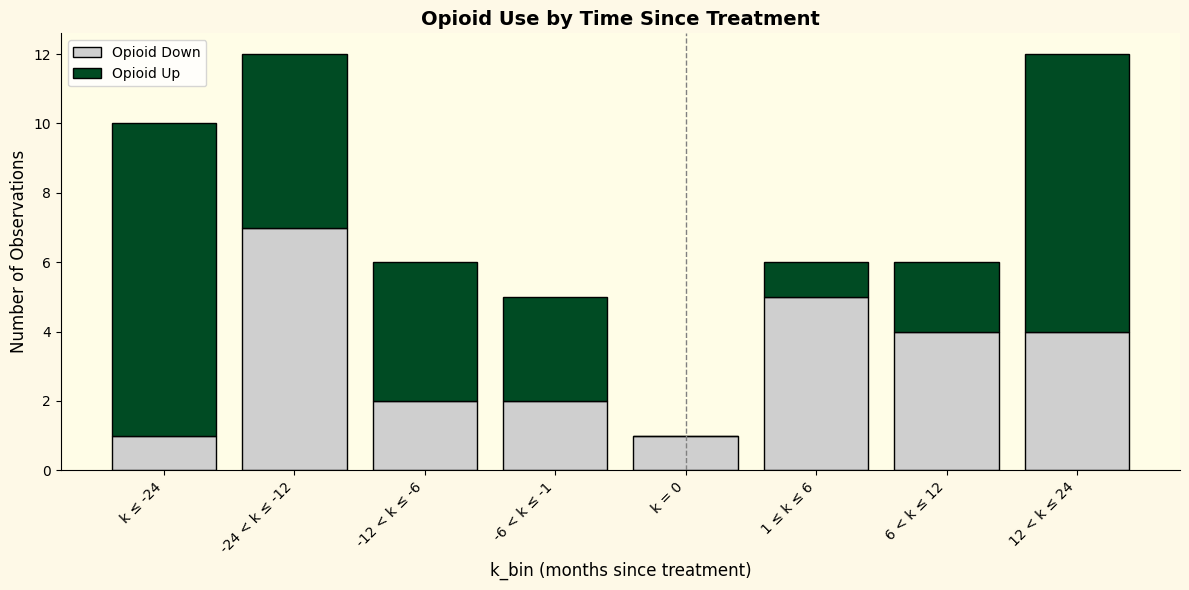

In [767]:
import matplotlib.pyplot as plt

# Define bin order (same as collapse_k logic)
bin_order = [
    "k ≤ -24",
    "-24 < k ≤ -12",
    "-12 < k ≤ -6",
    "-6 < k ≤ -1",
    "k = 0",
    "1 ≤ k ≤ 6",
    "6 < k ≤ 12",
    "12 < k ≤ 24",
]

# Count of 0/1 outcomes per bin
bin_outcomes = df.groupby(["k_bin", "opioids_up"]).size().unstack(fill_value=0).reindex(bin_order).fillna(0)

# Bar positions and colors
positions = list(range(len(bin_order)))
colors = {
    0: "#cfcfcf",  # opioid_up = 0 (gray)
    1: "#004B23",  # opioid_up = 1 (dark green)
}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("#fef9e7")
ax.set_facecolor("#fffde7")

# Plot stacked bars
ax.bar(positions, bin_outcomes[0], color=colors[0], edgecolor="black", width=0.8, label="Opioid Down")
ax.bar(positions, bin_outcomes[1], bottom=bin_outcomes[0], color=colors[1], edgecolor="black", width=0.8, label="Opioid Up")

# X-axis formatting
ax.set_xticks(positions)
ax.set_xticklabels(bin_order, rotation=45, ha="right")

# Vertical line at treatment bin
ax.axvline(bin_order.index("k = 0"), color="gray", linestyle="--", linewidth=1)

# Labels and title
ax.set_title("Opioid Use by Time Since Treatment", fontsize=14, fontweight='bold')
ax.set_xlabel("k_bin (months since treatment)", fontsize=12)
ax.set_ylabel("Number of Observations", fontsize=12)
ax.legend()

# Clean up
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [768]:
formula = "opioids_up ~ C(k_bin) + " + " + ".join(covariates) + " + C(State)"
glm_bin = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
glm_bin.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             opioids_up   No. Observations:                   58
Model:                            GLM   Df Residuals:                       41
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.669
Date:                Thu, 22 May 2025   Deviance:                       47.337
Time:                        14:39:46   Pearson chi2:                     45.5
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4285
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -998.6500   5.76e+05     -0.002      0.999   -1.13e+06    1.13e+06
C(k_bin)[T.-24 < k ≤ -12]   -21.1668   1.87e+04     -0.001      0.999   -3.66e+04    3.66e+04
C(k_bin)[T.-6 < k ≤ -1]       0.4442      1.587      0.280      0.780      -2.667       3.556
C(k_bin)[T.1 ≤ k ≤ 6]       -19.3578   2.84e+04     -0.001      0.999   -5.56e+04    5.56e+04
C(k_bin)[T.12 < k ≤ 24]     100.6681   6.36e+04      0.002      0.999   -1.25e+05    1.25e+05
C(k_bin)[T.6 < k ≤ 12]      -20.0438   2.84e+04     -0.001      0.999   -5.56e+04    5.56e+04
C(k_bin)[T.k = 0]           -21.3870   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
C(k_bin)[T.k ≤ -24]         -42.4351   2.91e+04     -0.001      0.999   -5.71e+04     5.7e+04
C(State)[T.NH]            -8.581e-10   4.96e-07     -0.002      0.999   -9.74e-07    9.72e-07
Minimum_Wage                 41.6477   3.36e+04      0.001      0.999   -6.59e+04    6.59e+04
Unemployment_Rate             1.4095      1.020      1.382      0.167      -0.589       3.408
MJ_Arrests                   -3.0445   2104.698     -0.001      0.999   -4128.177    4122.088
GDP_per_capita                0.0006      0.001      1.111      0.267      -0.000       0.002
Arrests_per_100k             44.1183   2.64e+04      0.002      0.999   -5.17e+04    5.18e+04
Voters_percentage             0.0001      0.002      0.071      0.944      -0.003       0.003
Democratic_percentage        -2.2420     16.390     -0.137      0.891     -34.367      29.883
Republican_percentage        15.6286     46.309      0.337      0.736     -75.135     106.392
Covid_t                      -6.9283      8.249     -0.840      0.401     -23.096       9.239
=============================================================================================
"""

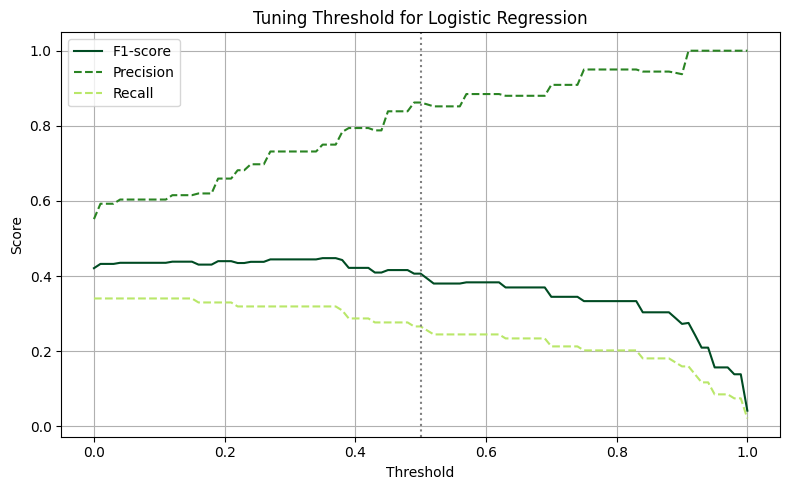

✅ Best Threshold (by F1): 0.35


In [769]:
from sklearn.metrics import precision_recall_fscore_support, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities
probs = glm_bin.predict(df)
true_labels = df["opioids_up"].values

# Try thresholds from 0.0 to 1.0
thresholds = np.linspace(0, 1, 101)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(true_labels, preds, average="binary", zero_division=0)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# Plot F1 score vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1-score", color="#004B23")
plt.plot(thresholds, precisions, label="Precision", linestyle="--", color="#2a8423")
plt.plot(thresholds, recalls, label="Recall", linestyle="--", color="#b9e769")
plt.axvline(x=0.5, color="gray", linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Tuning Threshold for Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"✅ Best Threshold (by F1): {best_threshold:.2f}")



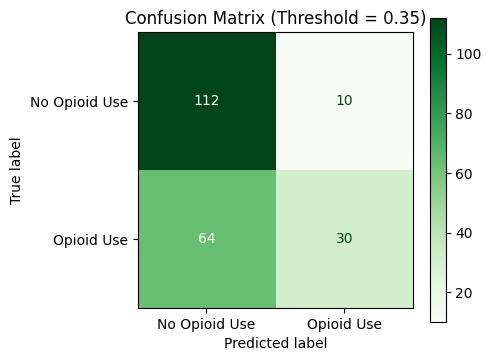

In [770]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

final_preds = (probs >= best_threshold).astype(int)

# 3. Actual labels
true_labels = df["opioids_up"]

# 4. Confusion matrix
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Opioid Use", "Opioid Use"])

# 5. Plot
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Greens")
ax.set_title("Confusion Matrix (Threshold = 0.35)")
plt.tight_layout()
plt.show()


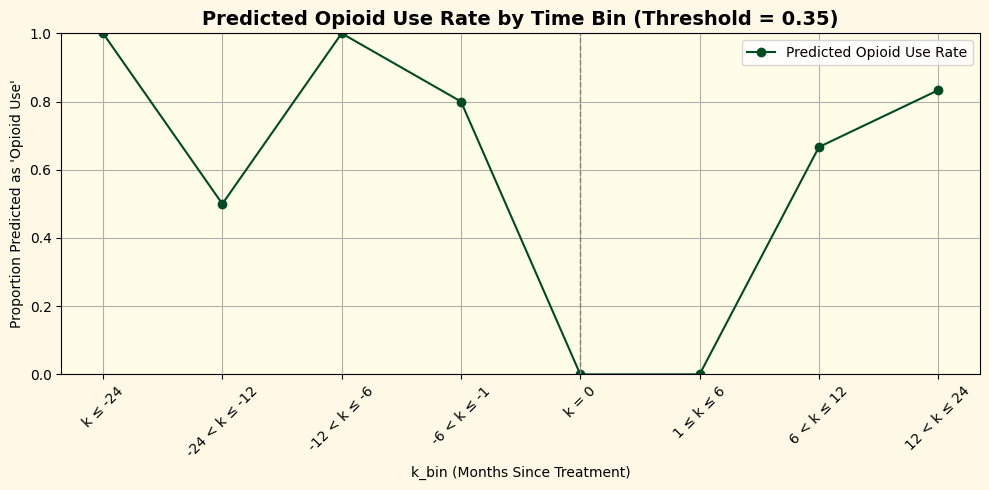

In [771]:
import matplotlib.pyplot as plt
import pandas as pd

# Define your bin order
bin_order = [
    "k ≤ -24",
    "-24 < k ≤ -12",
    "-12 < k ≤ -6",
    "-6 < k ≤ -1",
    "k = 0",
    "1 ≤ k ≤ 6",
    "6 < k ≤ 12",
    "12 < k ≤ 24",
]

# Predict probabilities from model
df["predicted_prob"] = glm_bin.predict(df)

# Use your best threshold (assume it's already computed)
# Replace this line with your actual threshold if needed
# best_threshold = 0.42  # Example
final_preds = (df["predicted_prob"] >= best_threshold).astype(int)
df["final_pred"] = final_preds

# Group by k_bin and compute average predicted class (0/1)
predicted_rate_by_bin = df.groupby("k_bin")["final_pred"].mean().reindex(bin_order)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("#fef9e7")
ax.set_facecolor("#fffde7")

ax.plot(bin_order, predicted_rate_by_bin, marker="o", linestyle="-", color="#004B23", label="Predicted Opioid Use Rate")
ax.axvline(x=bin_order.index("k = 0"), color="gray", linestyle="--", linewidth=1)

# Labels
ax.set_title(f"Predicted Opioid Use Rate by Time Bin (Threshold = {best_threshold:.2f})", fontsize=14, fontweight="bold")
ax.set_xlabel("k_bin (Months Since Treatment)")
ax.set_ylabel("Proportion Predicted as 'Opioid Use'")
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Binned relative-time dummies provide a more parsimonious, stable, and interpretable way to detect temporal patterns around the policy change.

### Test Placebo: Validazione dell’identificazione

Verificare che l’effetto stimato nel modello principale non sia dovuto a trend preesistenti o a shock comuni che nulla hanno a che vedere con la policy.

Lo facciamo simulando una legalizzazione fittizia avvenuta nel 2017, cioè prima della vera legalizzazione.

In [772]:
# Finta data di policy: gennaio 2017
placebo_date = pd.to_datetime("2017-01-01")

# Variabile treated_post_placebo: 1 solo per Massachusetts dopo finta legalizzazione
df["treated_post_placebo"] = ((df["treated"] == 1) & (df["Date"] >= placebo_date)).astype(int)


In [773]:
placebo_outcome = "opioids_all"
# Costruisci la formula (stesso set di covariate)
placebo_formula = f"{placebo_outcome} ~ treated_post_placebo + {' + '.join(covariates)} + C(State) + C(Date)"
# Stima OLS con robust standard errors
placebo_model = smf.ols(formula=placebo_formula, data=df).fit(cov_type="HC1")
pval = placebo_model.pvalues.get("treated_post_placebo")
print("Placebo test: effetto fittizio (policy nel 2017)")
print(f"p-value: {pval:.4f}")


Placebo test: effetto fittizio (policy nel 2017)
p-value: 0.1572


In [774]:
coef = placebo_model.params.get("treated_post_placebo")
se = placebo_model.bse.get("treated_post_placebo")
coef, se

(-1.4715977296706322, 1.040230360761949)

Se p-value > 0.05 → nessun effetto placebo, quindi tutto ok ✅

In [775]:
results_df

,Outcome,Coef. (treated_post),Std. Err.,p-value,Significant (p < 0.05)
0,All Opioids,1.838523,0.982544,0.061319,❌
1,Synthetic Opioids,2.191480,1.034860,0.034204,✅
2,Cocaine,-2.920001,0.661099,0.000010,✅
3,Natural/Semi-synthetic,0.428268,0.371697,0.249240,❌
4,Natural Opioids,0.060339,0.455958,0.894720,❌
5,Natural & Synthetic,2.411190,1.016665,0.017708,✅
6,heroin,0.725359,0.271984,0.007655,✅
7,methadone,-0.288440,0.214709,0.179144,❌
8,psychostimulants,-0.661729,0.432241,0.125788,❌


In [776]:
# Estrai i valori dalla riga 'opioids_all'
opioids_row = results_df[results_df['Outcome'] == 'All Opioids'].iloc[0]
real_coef_op = opioids_row['Coef. (treated_post)']
real_se_op = opioids_row['Std. Err.']
real_ci = [real_se_op - 1.96 * real_se_op, real_se_op + 1.96 * real_se_op]

real_coef_op, real_se_op


(1.8385231340917434, 0.9825436153199979)

NameError: name 'real_coef' is not defined

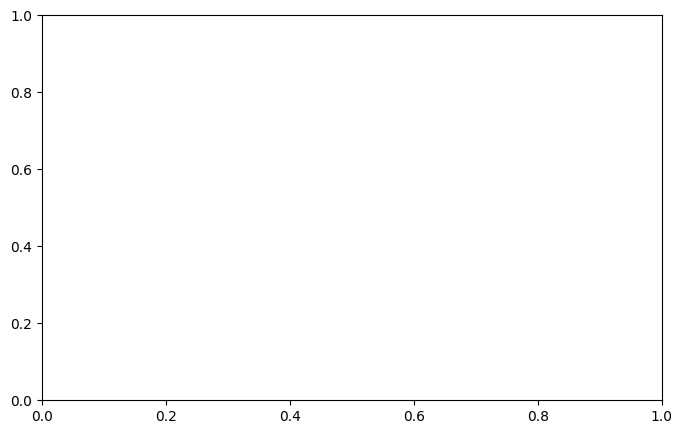

In [777]:

# Estrai coefficiente e intervallo per il placebo
placebo_coef = placebo_model.params.get("treated_post_placebo")
placebo_se = placebo_model.bse.get("treated_post_placebo")
placebo_ci = [placebo_coef - 1.96 * placebo_se, placebo_coef + 1.96 * placebo_se]

# Setup plot
fig, ax = plt.subplots(figsize=(8, 5))

# Punti con CI
ax.errorbar(x=["Reale", "Placebo"],
            y=[real_coef, placebo_coef],
            yerr=[1.96 * real_se, 1.96 * placebo_se],
            fmt="o", capsize=8, color="blue", label="Effetto stimato")

# Linea orizzontale a 0
ax.axhline(0, color="black", linestyle="--", linewidth=1)

# Titolo e assi
ax.set_ylabel("Coefficiente su treated_post")
ax.set_title("Confronto tra effetto reale e placebo")
ax.legend()

# Mostra
plt.tight_layout()
plt.show()


L’effetto osservato nella policy reale non è attribuibile a dinamiche preesistenti o casuali, altrimenti anche il placebo sarebbe risultato significativo

In [ ]:
placebo_outcome = "cocaine"
# Costruisci la formula (stesso set di covariate)
placebo_formula = f"{placebo_outcome} ~ treated_post_placebo + {' + '.join(covariates)} + C(State) + C(Date)"
# Stima OLS con robust standard errors
placebo_model = smf.ols(formula=placebo_formula, data=df).fit(cov_type="HC1")
pval = placebo_model.pvalues.get("treated_post_placebo")
print("Placebo test: effetto fittizio (policy nel 2017)")
print(f"p-value: {pval:.4f}")

In [ ]:
coef = placebo_model.params.get("treated_post_placebo")
se = placebo_model.bse.get("treated_post_placebo")
coef, se

In [ ]:
# Estrai i valori dalla riga 'opioids_all'
opioids_row = results_df[results_df['Outcome'] == 'Cocaine'].iloc[0]
real_coef_coc = opioids_row['Coef. (treated_post)']
real_se_coc = opioids_row['Std. Err.']

real_coef_coc, real_se_coc


In [ ]:


# Estrai coefficiente e intervallo per il placebo
placebo_coef = placebo_model.params.get("treated_post_placebo")
placebo_se = placebo_model.bse.get("treated_post_placebo")
placebo_ci = [placebo_coef - 1.96 * placebo_se, placebo_coef + 1.96 * placebo_se]

# Setup plot
fig, ax = plt.subplots(figsize=(8, 5))

# Punti con CI
ax.errorbar(x=["Reale", "Placebo"],
            y=[real_coef, placebo_coef],
            yerr=[1.96 * real_se, 1.96 * placebo_se],
            fmt="o", capsize=8, color="blue", label="Effetto stimato")

# Linea orizzontale a 0
ax.axhline(0, color="black", linestyle="--", linewidth=1)

# Titolo e assi
ax.set_ylabel("Coefficiente su treated_post")
ax.set_title("Confronto tra effetto reale e placebo")
ax.legend()

# Mostra
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Define colors consistent with marijuana-themed palette
background_color = "#fef9e7"       # soft beige
axes_color = "#fffde7"             # plot area
point_color = "#004B23"            # dark green
highlight_color = "#B9E769"        # light green
neutral_color = "#cfcfcf"          # gray for placebo
vline_color = "#ff5e5e"            # soft red

# Simulate example data for opioids and cocaine (since we lack actual model output)
real_coef_opioids = 0.25895980340102615
real_se_opioids = 0.7679781641078083
placebo_coef_opioids = -2.7156178906560817
placebo_se_opioids = 0.8617108165526786

real_coef_cocaine = -3.210680026239885
real_se_cocaine = 0.801363564749033
placebo_coef_cocaine = -0.8031609270302152
placebo_se_cocaine = 0.7436736404437067

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.patch.set_facecolor(background_color)

# Opioids subplot
axs[0].set_facecolor(axes_color)
# Opioids subplot
axs[0].errorbar(x=["Real", "Placebo"],
                y=[real_coef_opioids, placebo_coef_opioids],
                yerr=[1.96 * real_se_opioids, 1.96 * placebo_se_opioids],
                fmt="o", capsize=8, color=point_color,
                ecolor=highlight_color if real_coef_opioids < 0 else neutral_color)
axs[0].axhline(0, color="gray", linestyle="--", linewidth=1)
axs[0].set_title("Opioids", fontsize=12, fontweight='bold')
axs[0].set_ylabel("Coefficient on treated_post", fontsize=10)

# Cocaine subplot
axs[1].set_facecolor(axes_color)
axs[1].errorbar(x=["Real", "Placebo"],
                y=[real_coef_cocaine, placebo_coef_cocaine],
                yerr=[1.96 * real_se_cocaine, 1.96 * placebo_se_cocaine],
                fmt="o", capsize=8, color=point_color,
                ecolor=highlight_color if real_coef_cocaine < 0 else neutral_color)
axs[1].axhline(0, color="gray", linestyle="--", linewidth=1)
axs[1].set_title("Cocaine", fontsize=12, fontweight='bold')

# Styling
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Placebo Test vs Real Effect (Marijuana Legalization)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
err  =  FMNCO

In [ ]:
#df.columns
# remove all var starting with "rel_month_"
df.drop(columns=[col for col in df.columns if col.startswith("rel_month_")], inplace=True)
df.drop(columns=["months_since_treatment"], inplace=True)
df.drop(columns=["treated_post_placebo"], inplace=True)

In [ ]:
# summary statistics df['opioids_all'
df['opioids_all'].describe()

In [ ]:
df = df.sort_values(["State", "Date"])  # Ordina per stato e tempo
df["opioids_up"] = df.groupby("State")["opioids_all"].diff().gt(0).astype(int)

In [ ]:
# select all num var
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
# corr matrix
corr_matrix = df[num_vars].corr()
# Plotting the correlation matrix
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Numerical Variables")
plt.show()


In [ ]:
df.drop(columns=["Population"], inplace=True)

In [ ]:
df.drop(columns=["Possession_per_100k"], inplace=True)
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
# corr matrix
corr_matrix = df[num_vars].corr()


In [ ]:
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
# corr matrix
corr_matrix = df[num_vars].corr()

# select corr values > 0.95
high_corr_vars = corr_matrix[(corr_matrix > 0.90) | (corr_matrix < -0.90)].stack().index.tolist()
# exlude the diagonal
high_corr_vars = [(x, y) for x, y in high_corr_vars if x != y]
# when u print print also the value
for x, y in high_corr_vars:
    print(f"Correlation between {x} and {y}: {corr_matrix.loc[x, y]:.2f}")

In [ ]:
df.drop(columns=["Undeclared_percentage"], inplace=True)

In [ ]:
df.drop(columns=["Sales_per_100k","Republican_percentage"], inplace=True)

In [ ]:
df.drop(columns=["Voters_percentage"], inplace=True)

In [ ]:
covariates = [
    'Unemployment_Rate',
    'MJ_Arrests',
    'Agencies',
    'GDP_per_capita',
    'Arrests_per_100k',
    'Democratic_percentage',
    'Covid_t'
]

In [ ]:
df

In [ ]:
covariates

In [ ]:
import statsmodels.formula.api as smf

model = smf.logit("opioids_up ~ treated_post + " + " + ".join(covariates) + " + C(State) + C(Date)", data=df)
result = model.fit(cov_type="HC1")
print(result.summary())


In [ ]:
df

In [ ]:
first_stage = smf.ols("treated_post ~ IV_policy + " + " + ".join(covariates) + " + C(State)", data=df).fit()
df["treated_post_hat"] = first_stage.fittedvalues
